In [1]:
import os
import anndata
import logging
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import leidenalg
import csv
from pandas import Timestamp
import re
import matplotlib.pyplot as plt
from scipy.stats import rankdata 
import scipy
import random
from scipy.stats.stats import pearsonr   
import scipy.sparse
from SCCAF import *
from scipy.stats import rankdata 
from scipy.stats.stats import pearsonr   


/rds/general/user/aalmeid2/home/.local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [58]:
sc.settings.verbosity =3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi=300,fontsize=10)

Running Scanpy 1.7.1, on 2021-08-05 12:53.


In [3]:
random_state=10
date="20210805"
path_to_fast="/rds/general/user/aalmeid2"
path_out=path_to_fast+"/projects/cardiac_single_cell_biology/live/DCM_project/"
path_in=path_to_fast+"/projects/cardiac_single_cell_biology/live/DCM_project/"

In [4]:
%load_ext rpy2.ipython


/rds/general/user/aalmeid2/home/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [5]:
def stacked_barplot(adata, xaxis, stack, xaxis_label, legend_label, shift_top=0.2, xaxis_rotation=45, figsize=(10,10), percent=True):
    tmp=pd.crosstab(adata.obs[xaxis],
                adata.obs[stack]).sum(axis=1)
    
    ax= pd.crosstab(adata.obs[xaxis], 
                    adata.obs[stack]).apply(lambda r: r/r.sum()*100, axis=1)
    #ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0, colors=colors)
    ax_1 = ax.plot.bar(figsize=figsize,stacked=True, rot=0)
    #display(ax)
    #plt.legend(title="Subject") # loc='upper center', bbox_to_anchor=(0.1, 1.0), 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=legend_label)
    plt.xlabel(xaxis_label,fontweight="bold")
    plt.ylabel('Percent Distribution',fontweight="bold")
    
    if percent:
        for rec in ax_1.patches:
            height = rec.get_height()
            ax_1.text(rec.get_x() + rec.get_width() / 2, rec.get_y() + height/2, "{:.0f}%".format(height),
                   ha = 'center', va='center', fontsize=14.5, weight='bold') #
    
    for xaxistick in range(ax.shape[0]):
        ax_1.text(xaxistick-shift_top,110,tmp[xaxistick],va='center', rotation=45, fontsize=14.5, weight='bold')
    
    plt.xticks(rotation=xaxis_rotation)
    
    ax_1.grid(False)
    plt.show()

In [6]:
def makevector_topmarkers(anndata, top_n, ldFC_cutoff=0.5, pvals_adj_cutoff=10**-30, expression_in=1,expression_out=1): 
    results=anndata.uns['rank_genes_groups']
    clusters = results['names'].dtype.names
    top_genes=[]
    for cluster in clusters:
        topgenes_cluster=results['names'][cluster][np.where((results['logfoldchanges'][cluster]>=ldFC_cutoff) & 
                                                            (results['pvals_adj'][cluster]<(pvals_adj_cutoff)) &
                                                            (results['eo'][cluster]<=expression_out) &
                                                           (results['ei'][cluster]>=expression_in))][0:top_n]
        top_genes.extend(topgenes_cluster)
    return(top_genes)

In [7]:
def makevector_topmarkers_incluster(anndata, top_n, cluster, ldFC_cutoff=0.5, pvals_adj_cutoff=10**-30, expression_in=1): 
    results=anndata.uns['rank_genes_groups']
    clusters = results['names'].dtype.names
    
    top_genes=results['names'][cluster][np.where((results['logfoldchanges'][cluster]>=ldFC_cutoff) & 
                                                            (results['pvals_adj'][cluster]<(pvals_adj_cutoff)) &
                                                           (results['ei'][cluster]>=expression_in))][0:top_n]
    return(top_genes)

In [8]:
def filter_by_expression(adata_obj, DE_column, key='rank_genes_groups'):
#adata_obj=fbs_new_harmony.copy()
#key='rank_genes_groups'
#DE_column='leiden'
    def to_tensor(dataframe, columns = [], dtypes = {}, index = False):
        to_records_kwargs = {'index': index}
        if not columns:  # Default to all `dataframe.columns`
            columns = dataframe.columns
        if dtypes:       # Pull in modifications only for dtypes listed in `columns`
            to_records_kwargs['column_dtypes'] = {}
            for column in dtypes.keys():
                if column in columns:
                    to_records_kwargs['column_dtypes'].update({column: dtypes.get(column)})
        return dataframe[columns].to_records(**to_records_kwargs)
    gene_names = pd.DataFrame(adata_obj.uns[key]['names'])
    fraction_in_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    fraction_notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    in_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allin_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allnotin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    # Create a Adata raw with raw in .X -> We might remove this step - redundant!
    dummy=anndata.AnnData(X=adata_obj.raw.X,
                   var=adata_obj.raw.var,
                   obs=adata_obj.obs)
    # We split the adata by Cell-type. Genes are ordered according to ranks from DEgene analysis
    dummy_split=[dummy[dummy.obs[DE_column].isin([i]),
                  gene_names[i]] for i in gene_names.columns]
    dummy_split_adatasize=[i.shape[0] for i in dummy_split] # How many cells we have in-cluster
    dummy_outcluster=[dummy[~dummy.obs[DE_column].isin([i]),
                       gene_names[i]] for i in gene_names.columns]
    dummy_split_adatasize_outcluster=[i.shape[0] for i in dummy_outcluster] # How many cells we have in out-cluster
    for adata, sizeof_adata, adata_outcluster, sizeof_adata_outcluster in zip(dummy_split, dummy_split_adatasize, 
                                                     dummy_outcluster, dummy_split_adatasize_outcluster):
        cluster_number=[(adata.obs[DE_column].unique()).tolist()][0]
        #incluster_rows, incluster_cols=adata.X.nonzero()
        #https://stackoverflow.com/questions/3797158/counting-non-zero-elements-within-each-row-and-within-each-column-of-a-2d-numpy
        #incluster_counts = [len(np.where(incluster_cols==i)[0]) for i in range(0,adata.shape[1])]
        incluster_counts=np.diff(adata.X.tocsc().indptr)
        percent_expression_incluster=np.array(incluster_counts)/sizeof_adata 
        fraction_in_cluster_matrix[cluster_number[0]]=percent_expression_incluster
        #outcluster_rows, outcluster_cols=adata_outcluster.X.nonzero()
        #outcluster_counts = [len(np.where(outcluster_cols==i)[0]) for i in range(0,adata_outcluster.shape[1])]
        outcluster_counts=np.diff(adata_outcluster.X.tocsc().indptr)
        percent_expression_outcluster=np.array(outcluster_counts)/sizeof_adata_outcluster 
        fraction_notin_cluster_matrix[cluster_number[0]]=percent_expression_outcluster
        # Expression_all in cluster
        allin_cluster_expr_matrix[cluster_number[0]]=np.squeeze(np.asarray(adata.X.mean(axis=0)))
        allnotin_cluster_matrix[cluster_number[0]]=np.squeeze(np.asarray(adata_outcluster.X.mean(axis=0)))
    # Generate the last table results
    result = adata_obj.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result['pi'] = to_tensor(fraction_in_cluster_matrix)
    result['po'] = to_tensor(fraction_notin_cluster_matrix)
    result['ei'] = to_tensor(allin_cluster_expr_matrix)
    result['eo'] = to_tensor(allnotin_cluster_matrix)
    results =pd.DataFrame(
        {group + '_' + key[:2]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges', 'pi', 'po', "ei", "eo"]})
    return results

In [9]:
def plot_celltype_abundance(adata_obs, Region, variable='leiden_annotated', 
                            normalised_by=None, 
                            Genes_column='Gene',
                            Genes_to_plot=['PKP2', 'LMNA', 'PLN', 'RBM20', 'TTN', 'DES', 'control', 'mutation negative'], 
                            celltypes_to_plot=['CM', 'FB', 'MP', 'EC'], plottype="boxplot", 
                            show_points=True, return_table=False, save_png=None, ylimit=None):
    # Example how to use this function=
    # plot_celltype_abundance(adata_obs, 'AP', 'global_annotated'), where adata_obs=adata.obs
    
    count=0 # This is needed in case one genotype is not found
    
    # Subsetting for region
    if Region == "LV":
        tmp=adata_obs[adata_obs['Region'].isin(['FW', 'AP'])]
    
    elif Region == "LVS":
        tmp=adata_obs[adata_obs['Region'].isin(['FW', 'AP', 'S'])]
    
    elif Region == "all":
        tmp=adata_obs
    else:
        tmp=adata_obs[adata_obs['Region'].isin([Region])]
    
    # Calculates percentage per gene
    for gene_nr in range(len(Genes_to_plot)):
    #gene_nr=0
        Gene=Genes_to_plot[gene_nr]
        tmp_=tmp[tmp[Genes_column].isin([Gene])]
        ax= pd.crosstab(tmp_['Patient'], 
                        tmp_[variable]).apply(lambda r: r/r.sum()*100, axis=1).copy()
        if ax.shape[0]==0:
            continue
        if celltypes_to_plot is not None:
            ax=ax[celltypes_to_plot]#, 'FB', 'EC', 'MP', 'PC']]
            celltypes_to_plot=celltypes_to_plot[0:]
        if normalised_by is not None:
            normalize=ax[normalised_by]
            ax=ax.apply(lambda r: r/normalize, axis=0)
            y_axis_title="% celltype / "+ normalised_by
        else:
            y_axis_title="% celltype"
            
        index_ax = ax.index.to_frame(index=False) 
        ax = ax.reset_index(drop=True) 
        ax = pd.merge(index_ax, ax, left_index=True, right_index=True) 
        ax_melt=pd.melt(ax, id_vars='Patient')
        ax_melt[Genes_column]=Gene + " (n=" + str(ax.shape[0]) + ")"
        if ax.shape[0] != 0: 
            if count==0:
                final_df = ax_melt
                count=+1
            else:
                final_df=pd.concat([final_df, ax_melt], axis=0)
                
    # If you want to have a table only
    if return_table == True:
        return final_df
    
    # If you want to have a plot only
    else:
        %matplotlib inline
        plt.figure(figsize=[14,10], dpi=200, facecolor='w', edgecolor='k')
        if plottype == "boxplot":
            sns.set_style(style='white')
            flierprops = dict(markerfacecolor='0.75', markersize=3,
                          linestyle='none')
            if show_points is True:
                ax=sns.swarmplot(x="variable", y="value", hue=Genes_column, data=final_df, color=".25", dodge=True, size=3)
            ax=sns.boxplot(x="variable", y='value', hue=Genes_column, data=final_df, flierprops=flierprops, showfliers = False)
            handles, labels = ax.get_legend_handles_labels()
            plt.legend(handles[0:len(set(final_df[Genes_column]))], labels[0:len(set(final_df[Genes_column]))], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set_ylabel(y_axis_title,fontsize=40)
            ax.set_xlabel("Cell type",fontsize=40)
            ax.tick_params(labelsize=30)
            if ylimit is not None:
                ax.set(ylim=(0, ylimit))
        elif plottype == "violinplot":           
            if show_points == True:
                ax = sns.violinplot(x="variable", y="value", hue=Genes_column, data=final_df, inner="points")
            else:
                ax = sns.violinplot(x="variable", y="value", hue=Genes_column, data=final_df) 
            handles, labels = ax.get_legend_handles_labels()
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
            plt.legend(handles[0:len(set(final_df[Genes_column]))], labels[0:len(set(final_df[Genes_column]))], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
            ax.set_ylabel(y_axis_title,fontsize=40)
            ax.set_xlabel("Cell type",fontsize=40)
            ax.tick_params(labelsize=30)
            ax
    
    # If you want to save the figure
    if save_png != None:
        plt.savefig(save_png, transparent=True)

In [10]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [11]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5, scatter_size=4):
    def colored_scatter(x, y, c=None, scatter_size=scatter_size):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs, s=scatter_size)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )
    # Do also global Hist:
    #sns.distplot(
    #    df[col_x].values,
    #    ax=g.ax_marg_x,
    #    color='grey'
    #)
    #sns.distplot(
    #    df[col_y].values.ravel(),
    #    ax=g.ax_marg_y,
    #    color='grey',
    #    vertical=True
    #)
    plt.legend(legends)

In [12]:
def prep_adata_forcellxgene(adata):
    adata=anndata.AnnData(X=adata.raw.X, 
                                         obs=adata.obs, 
                                         var=adata.raw.var, 
                                         uns=adata.uns, 
                                         obsm=adata.obsm)
    adata.obs=adata.obs[['Sample', 'Patient', 'Gender', 'Region', 'Diagnosis', 'Gene', 'Clinical.dominant.mutation', 
                         'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 
                         'cell_type', 'cell_states']]
    return adata
    #adata.write(path_out + "FB_ALL_LEIDEN_CELLXGENE2.h5ad")

In [13]:
def correlation_analysis(scanpy_object, column_tosplitby, sum_or_mean):
    d = {}
    for cluster_number in np.unique(scanpy_object.obs[column_tosplitby].values):
        #cluster_number=np.unique(heart.obs['louvain_annotated'].values)[1]
        scanpy_object_subset = scanpy_object[scanpy_object.obs[column_tosplitby].isin([cluster_number])]

        if sum_or_mean=="mean":
            d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.mean(axis=0))) #np.log(+1)
        elif sum_or_mean=="sum":
            d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.sum(axis=0))) #np.log(+1)
        del scanpy_object_subset
        
    return d

In [14]:
def percentage_gene(adata, Gene_list, celltype_column, Condition_column):
    
    adata.obs['Combined_label']=[str(i) + "_" + str(j) for i,j in zip(adata.obs[celltype_column], adata.obs[Condition_column])]
    states=adata.obs['Combined_label'].unique().tolist()
    
    def percent_inout_one(adata, Gene_list, state): 
        in_cluster_cells=adata.obs.Combined_label.isin([state])
        total_out_cluster=adata.shape[0]-len(np.where(in_cluster_cells))
    
        in_nonzeroes=np.diff(adata.raw[in_cluster_cells,Gene_list].X.tocsc().indptr)
        percent_incluster=in_nonzeroes/len(np.where(in_cluster_cells)[0])
        not_in_nonzeroes=np.diff(adata.raw[~in_cluster_cells,Gene_list].X.tocsc().indptr)
        percent_outcluster=not_in_nonzeroes/total_out_cluster
        
        return(np.concatenate((percent_incluster, percent_outcluster)))
    
    out=[percent_inout_one(adata, Gene_list, state) for state in states]
    colnames=np.asarray([str(i) + "_in" for i in Gene_list] + [str(i) + "_out" for i in Gene_list])
    df=pd.DataFrame(out, 
                    index=states,
                    columns=colnames)
    return df

In [15]:
def correlation_analysis(scanpy_object, column_tosplitby, sum_or_mean):
  d = {}
  for cluster_number in np.unique(scanpy_object.obs[column_tosplitby].values):
    #cluster_number=np.unique(heart.obs['louvain_annotated'].values)[1]
    scanpy_object_subset = scanpy_object[scanpy_object.obs[column_tosplitby].isin([cluster_number])]
    if sum_or_mean=="mean":
      d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.mean(axis=0))) #np.log(+1)
    elif sum_or_mean=="sum":
      d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.sum(axis=0))) #np.log(+1)
    del scanpy_object_subset
  return d

### All data prep

In [52]:
ec_all_nobackground_harmony=sc.read_h5ad(path_in + "ec_20210804_no_Doublets.h5ad")

In [53]:
ec_all_nobackground_harmony_2=ec_all_nobackground_harmony[~ec_all_nobackground_harmony.obs.Sample.isin(["BO_H08_LV0_premrna", "BO_H12_RV0_premrna", 'BO_H40_LV1_premrna', 'BO_H40_LVW_premrna', 'BO_H49_LV1_premrna', 'BO_H51_LV1_premrna'])].copy()

In [54]:
ec_all_nobackground_harmony_3=ec_all_nobackground_harmony[ec_all_nobackground_harmony.obs.CDM.isin(["Control","LMNA","TTN","RBM20","PKP2","PVneg"])].copy()

In [55]:
ec7=ec_all_nobackground_harmony_3[ec_all_nobackground_harmony_3.obs["cell_states"]=="EC7.0"]

In [56]:
ec2_2=ec_all_nobackground_harmony_2[ec_all_nobackground_harmony_2.obs["cell_states"]=="EC2.0"]

In [57]:
ec7_2=ec_all_nobackground_harmony_2[ec_all_nobackground_harmony_2.obs["cell_states"]=="EC7.0"]

### Main Figure

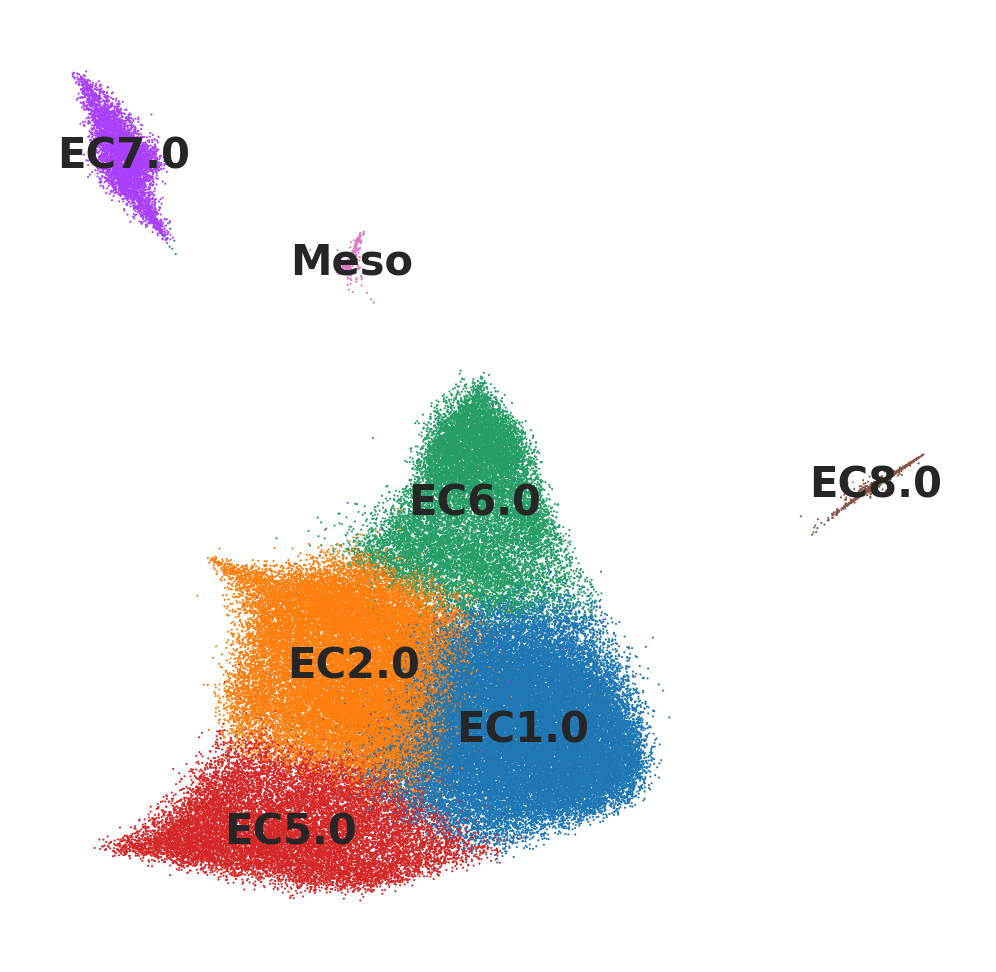

In [59]:
sc.pl.umap(ec_all_nobackground_harmony, color='cell_states', legend_loc='on data', title='', frameon=False, save='_ec.pdf')

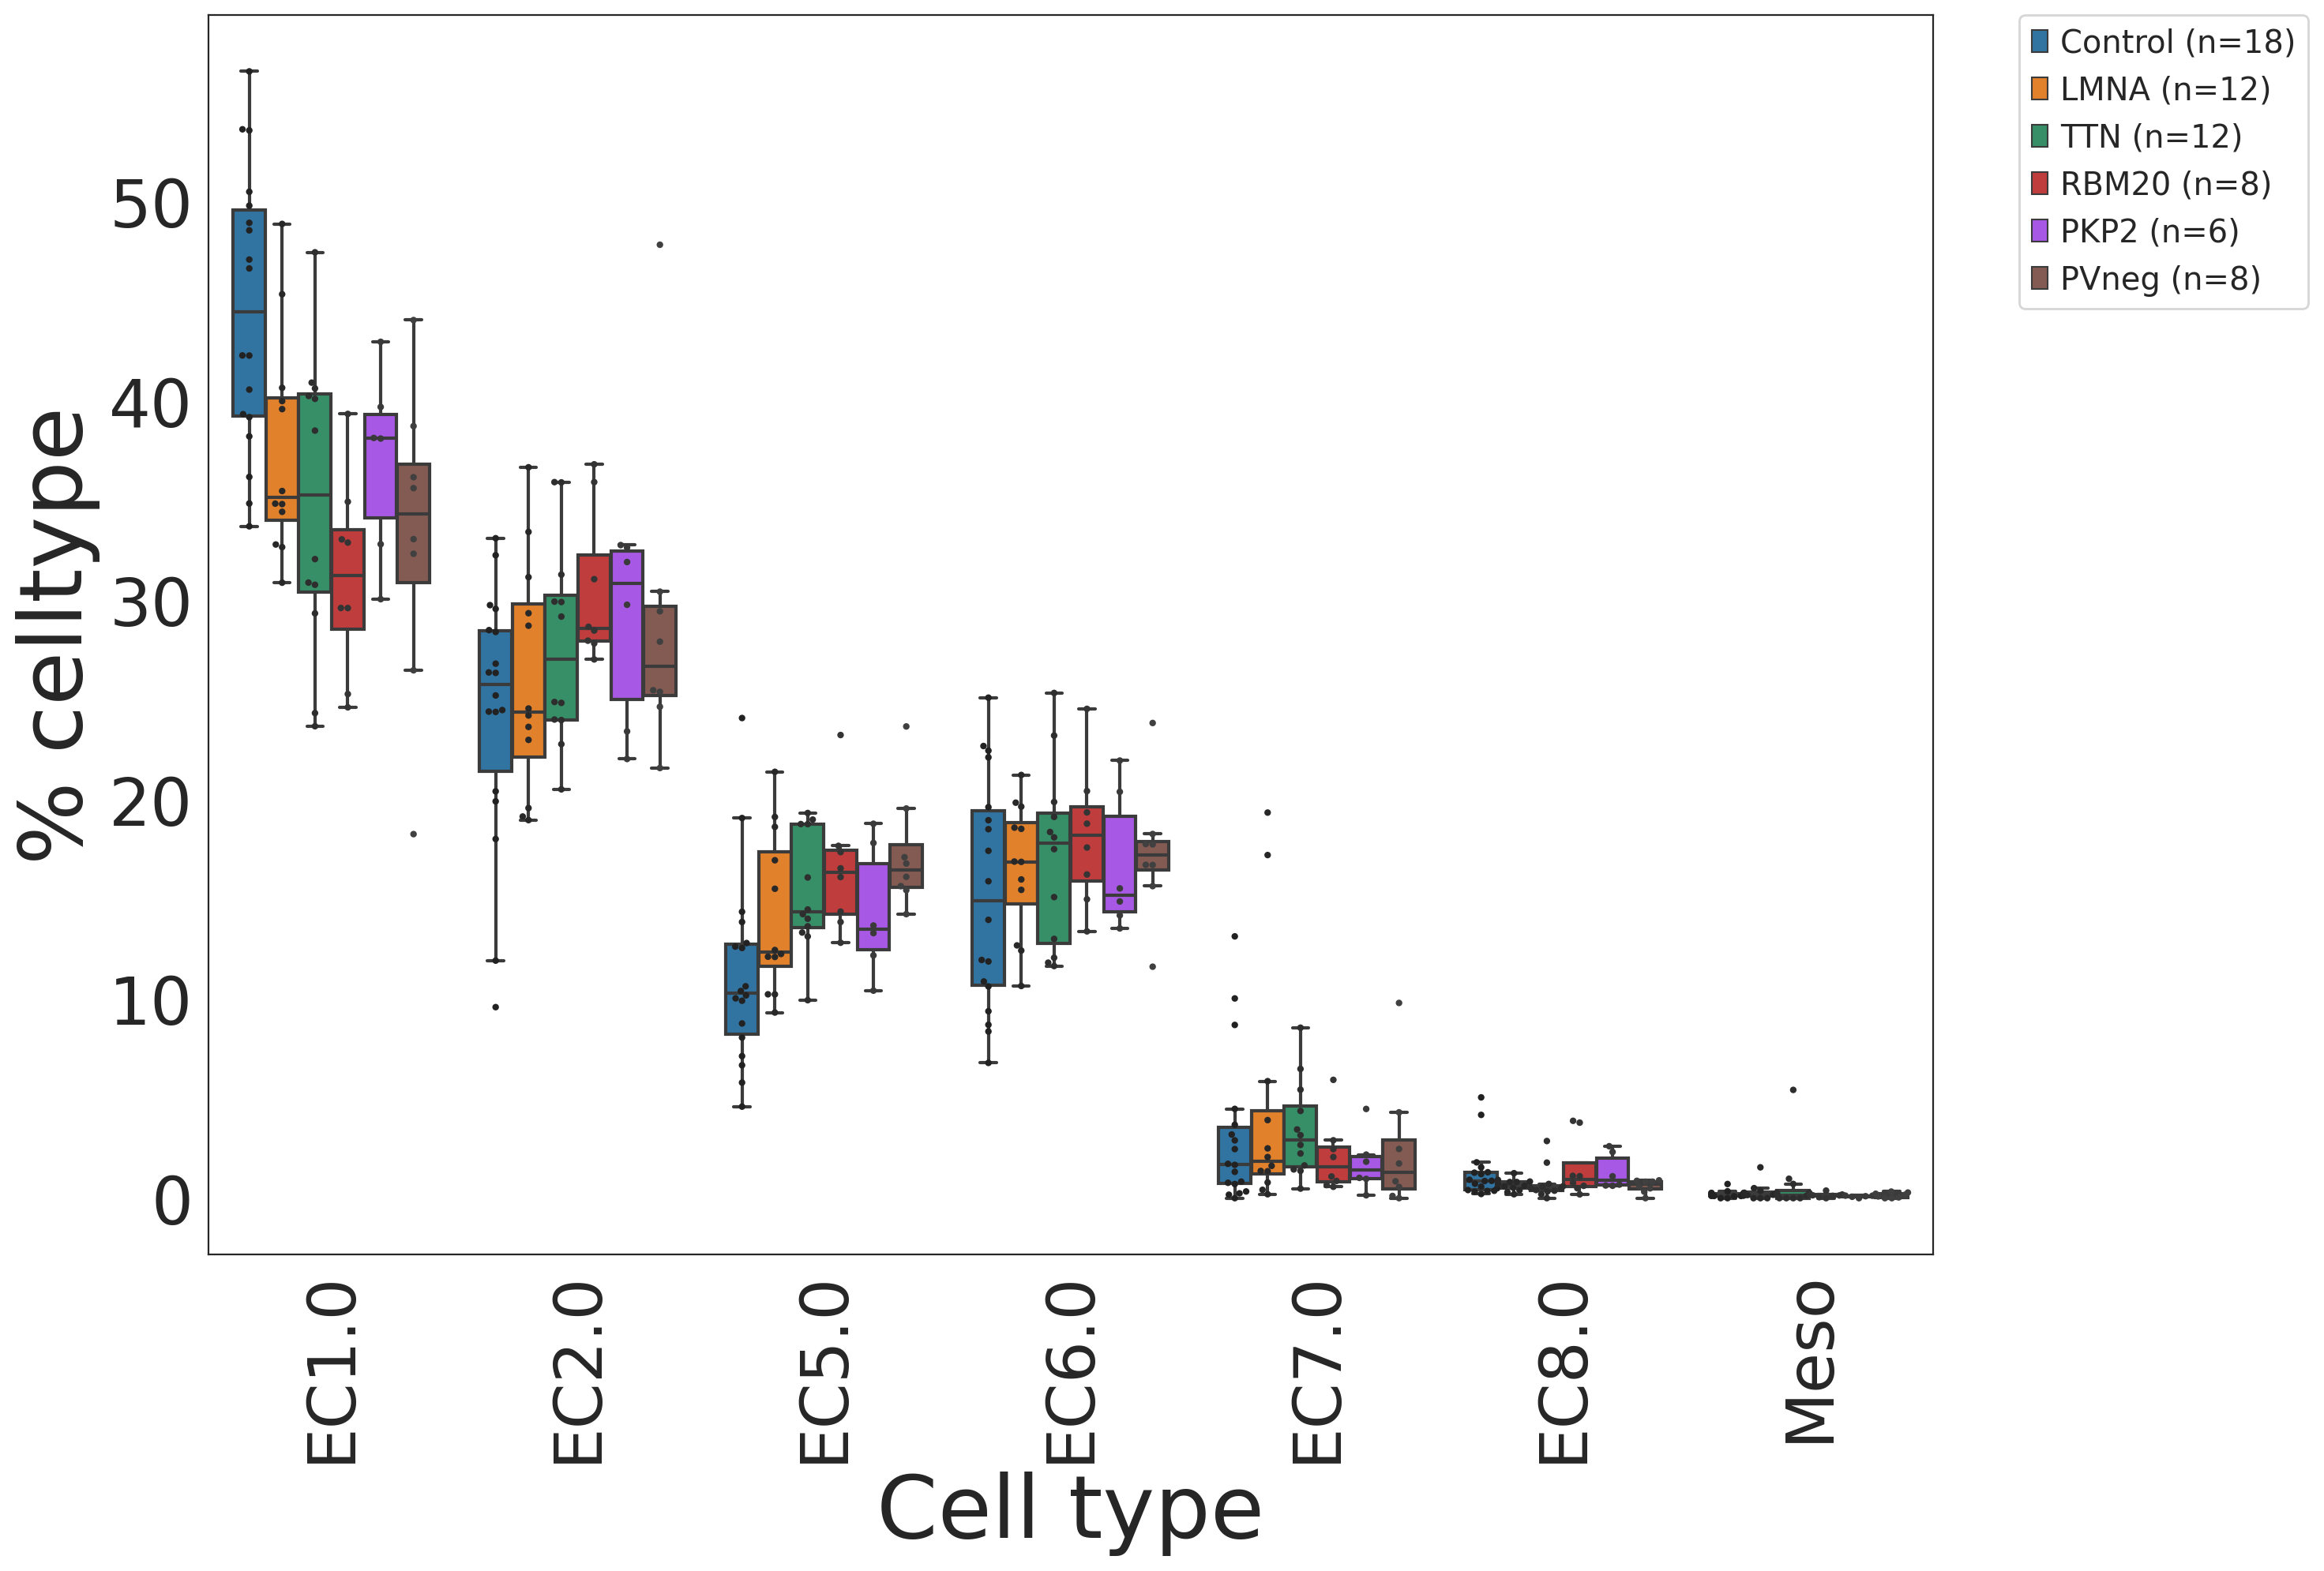

In [60]:
plot_celltype_abundance(ec_all_nobackground_harmony_2.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['EC1.0', 'EC2.0', 'EC5.0', 
                                               'EC6.0','EC7.0', 'EC8.0','Meso'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png="ec_abundance_boxplot_lv.pdf", ylimit=None)

In [61]:
x=plot_celltype_abundance(ec_all_nobackground_harmony_2.obs, 'LVS', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['EC1.0', 'EC2.0', 'EC5.0', 
                                               'EC6.0','EC7.0', 'EC8.0','Meso'], 
                            plottype="boxplot", 
                            show_points=True, return_table=True, save_png=None, ylimit=None)

In [62]:
x.columns=['Patient', 'cell_states', 'abundance_percent', 'Mutation']
x

,Patient,cell_states,abundance_percent,Mutation
0,BS_H15,EC1.0,42.273442,Control (n=18)
1,BS_H20,EC1.0,47.082768,Control (n=18)
2,BS_H25,EC1.0,48.926014,Control (n=18)
3,BS_H26,EC1.0,39.327731,Control (n=18)
4,BS_H35,EC1.0,50.483092,Control (n=18)
...,...,...,...,...
51,H56,Meso,0.000000,PVneg (n=8)
52,H57,Meso,0.281690,PVneg (n=8)
53,H58,Meso,0.328947,PVneg (n=8)
54,H59,Meso,0.167691,PVneg (n=8)


In [63]:
x.to_csv(path_out + "EC_CELLSTATE_ABUNDANCE_LV.csv")

In [64]:
marker_genes=["SMOC1","NPR3","POSTN","INHBA","OPCML","NRG3","NRG1","BMP6","MYO10", "EDN1"]

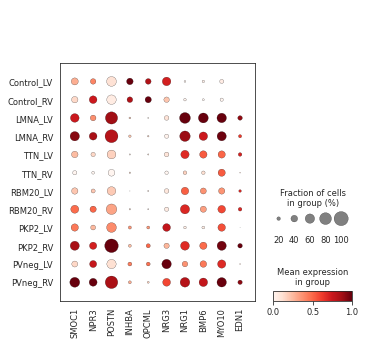

In [65]:
sc.pl.dotplot(ec7,marker_genes,groupby="CDM_region",dot_max=1,dot_min=0.05,standard_scale="var",categories_order=["Control_LV","Control_RV","LMNA_LV","LMNA_RV","TTN_LV","TTN_RV","RBM20_LV","RBM20_RV","PKP2_LV","PKP2_RV","PVneg_LV","PVneg_RV"],swap_axes=False,save="ec7_markers_both_regions.pdf")

### Supplementary Data

In [66]:
marker_genes=["RGCC","CA4","SYN3","SEMA3G","VEGFC","LINC00639","ACKR1","RAMP3","LYST","SMOC1","NPR3","POSTN","PROX1","CCL21","MMRN1","MSLN","RBFOX1","C3"]

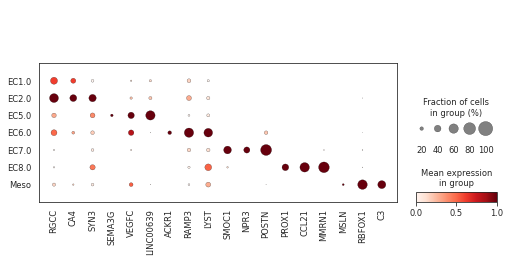

In [67]:
sc.pl.dotplot(ec_all_nobackground_harmony,marker_genes, groupby='cell_states',categories_order=["EC1.0","EC2.0","EC5.0","EC6.0","EC7.0","EC8.0","Meso"],dot_max=1,dot_min=0.05,standard_scale="var",save="ec_cluster_markers.pdf")

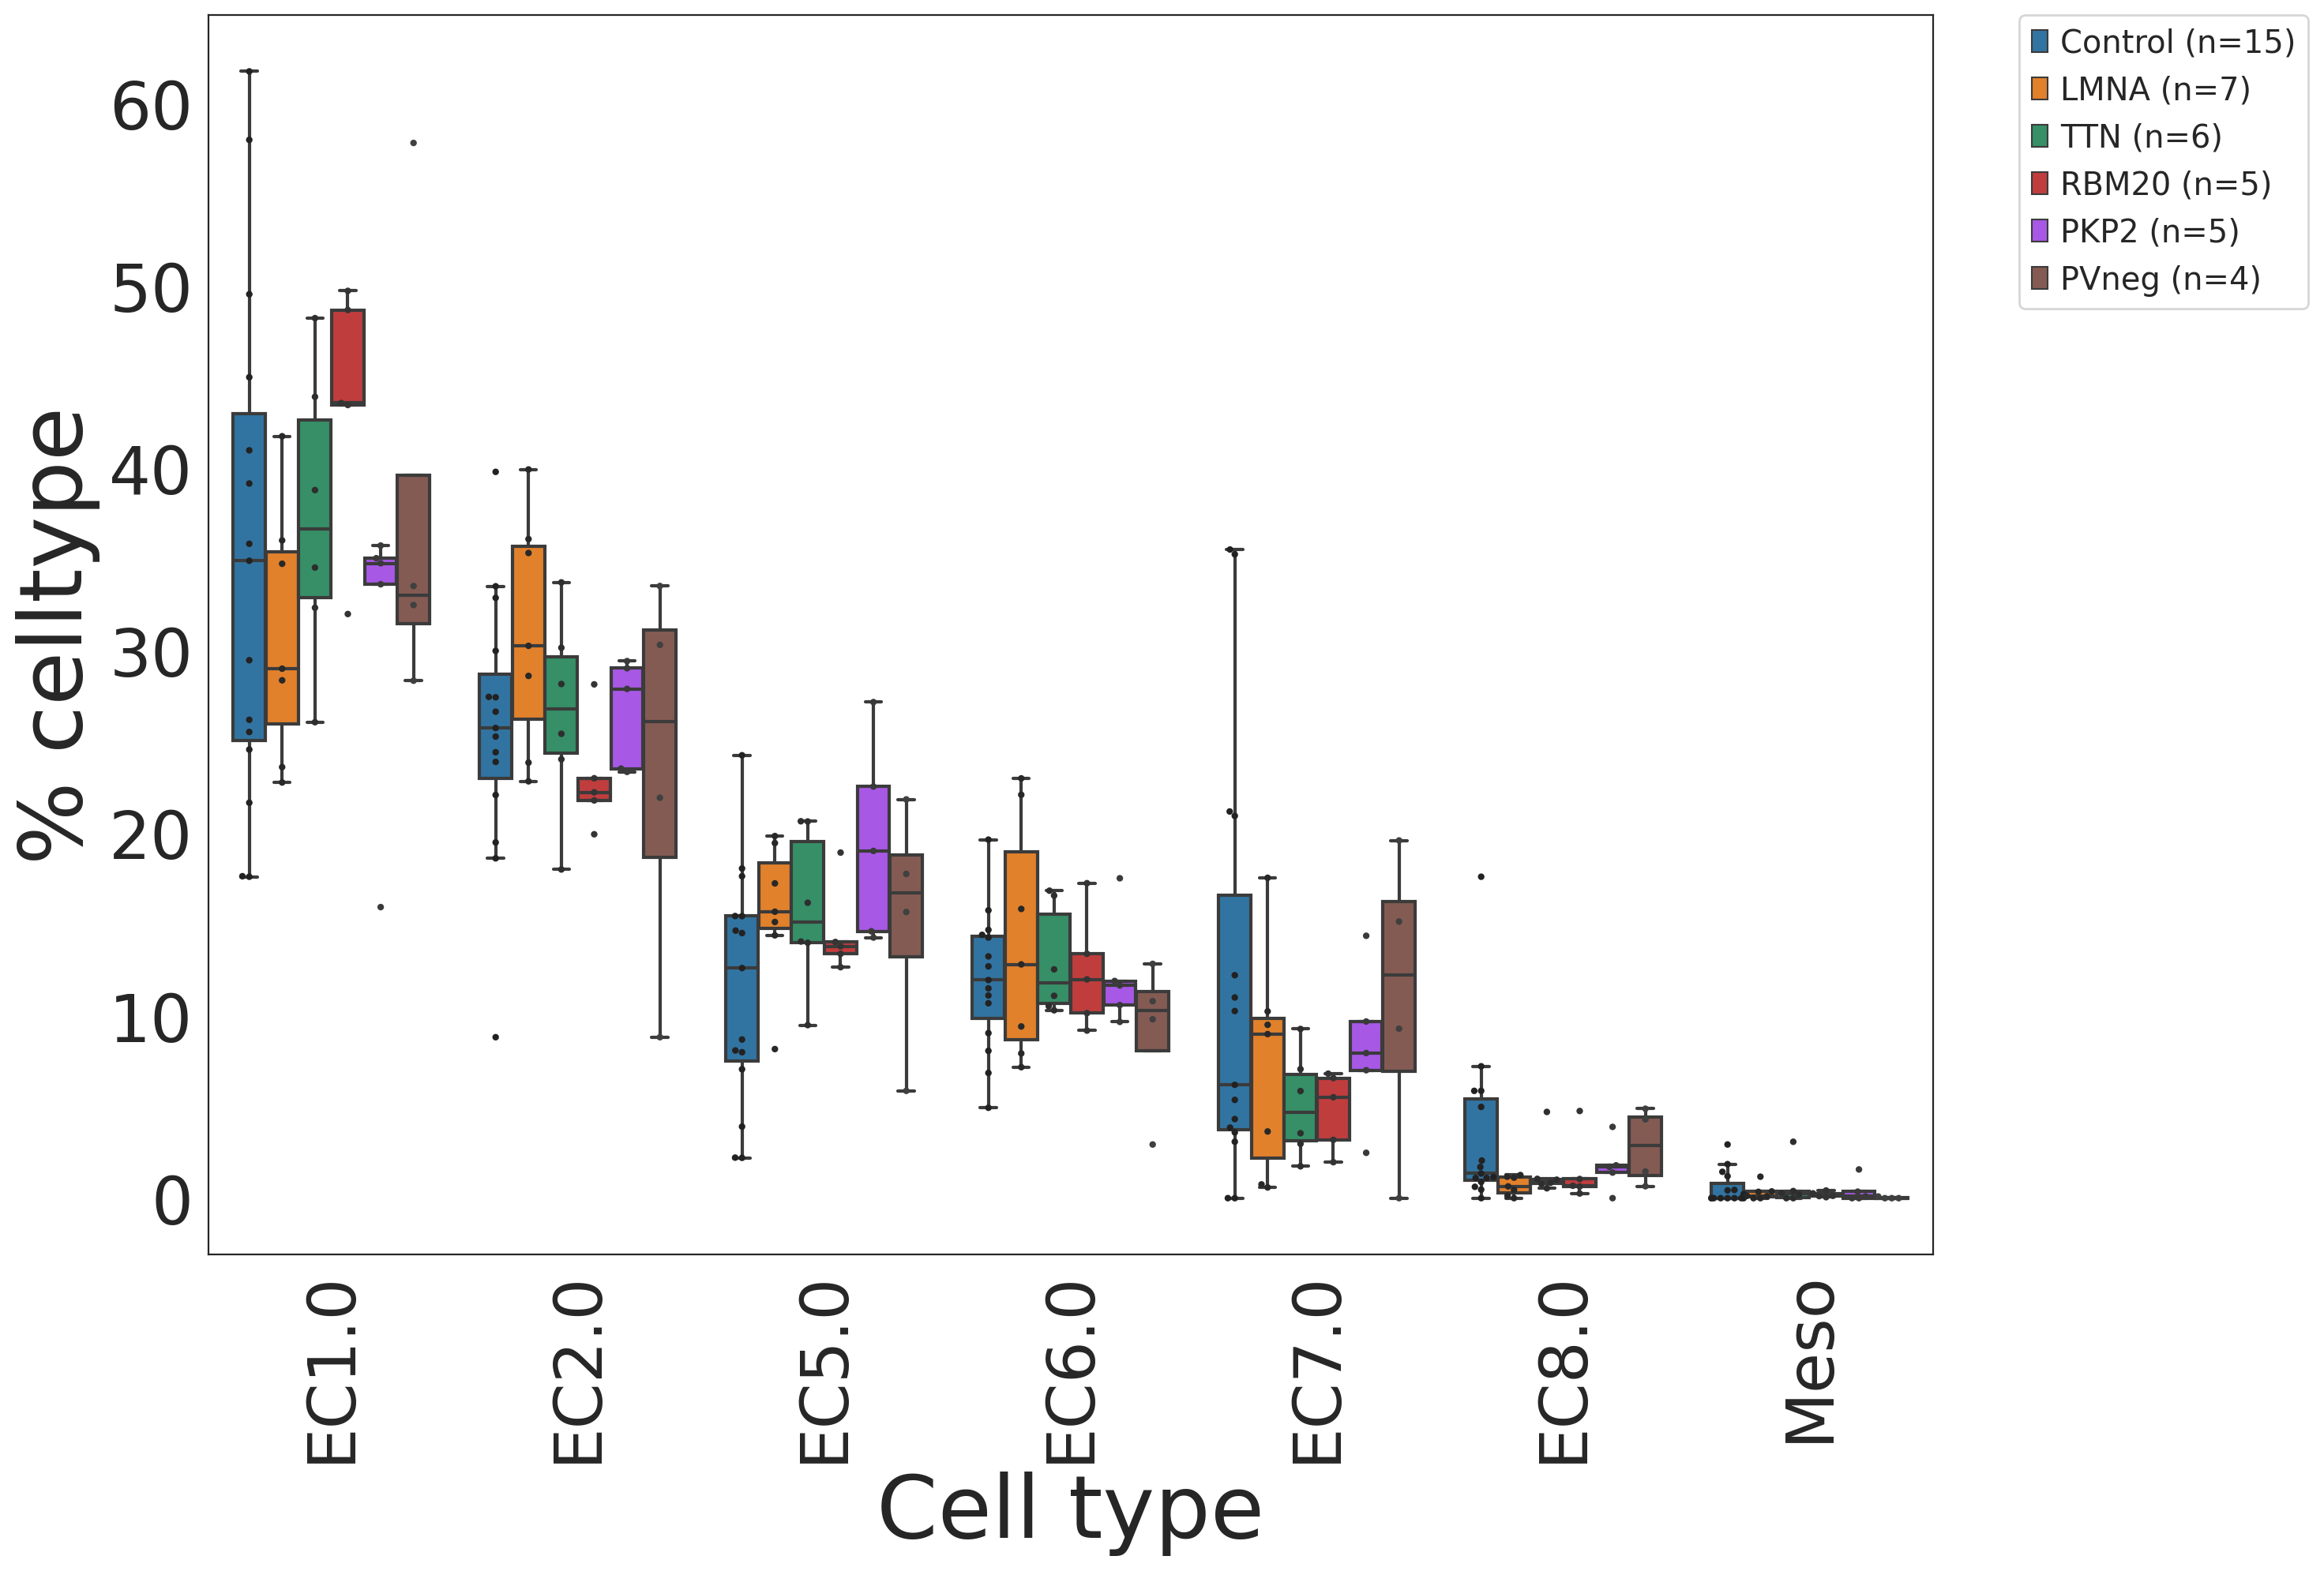

In [68]:
plot_celltype_abundance(ec_all_nobackground_harmony_2.obs, 'RV', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['EC1.0', 'EC2.0', 'EC5.0', 
                                               'EC6.0','EC7.0', 'EC8.0','Meso'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png="ec_abundance_boxplot_rv.pdf", ylimit=None)

In [69]:
x2=plot_celltype_abundance(ec_all_nobackground_harmony_2.obs, 'RV', variable='cell_states', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['EC1.0', 'EC2.0', 'EC5.0', 
                                               'EC6.0','EC7.0', 'EC8.0','Meso'], 
                            plottype="boxplot", 
                            show_points=True, return_table=True, save_png=None, ylimit=None)

In [70]:
x2.to_csv(path_out + "EC_CELLSTATE_ABUNDANCE_RV.csv")

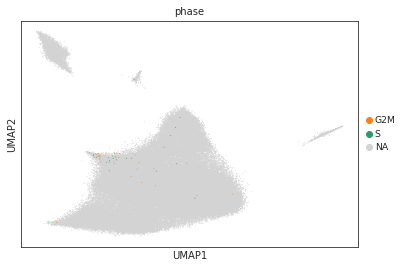

In [71]:
sc.pl.umap(ec_all_nobackground_harmony,color="phase",groups=["G2M","S"],size=3,save="_ec_cell_cycle.pdf")


In [72]:
ec2_lv_g1=plot_celltype_abundance(ec2_2.obs, 'LVS', variable='phase', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['G1'], 
                            plottype="boxplot", 
                            show_points=True, return_table=True, save_png=None, ylimit=None)

In [73]:
ec2_lv_g1["Cycling"]=100-ec2_lv_g1["value"]

In [74]:
ec2_lv_g1["variable"] = ec2_lv_g1["variable"].replace({"G1":"Cycling"})

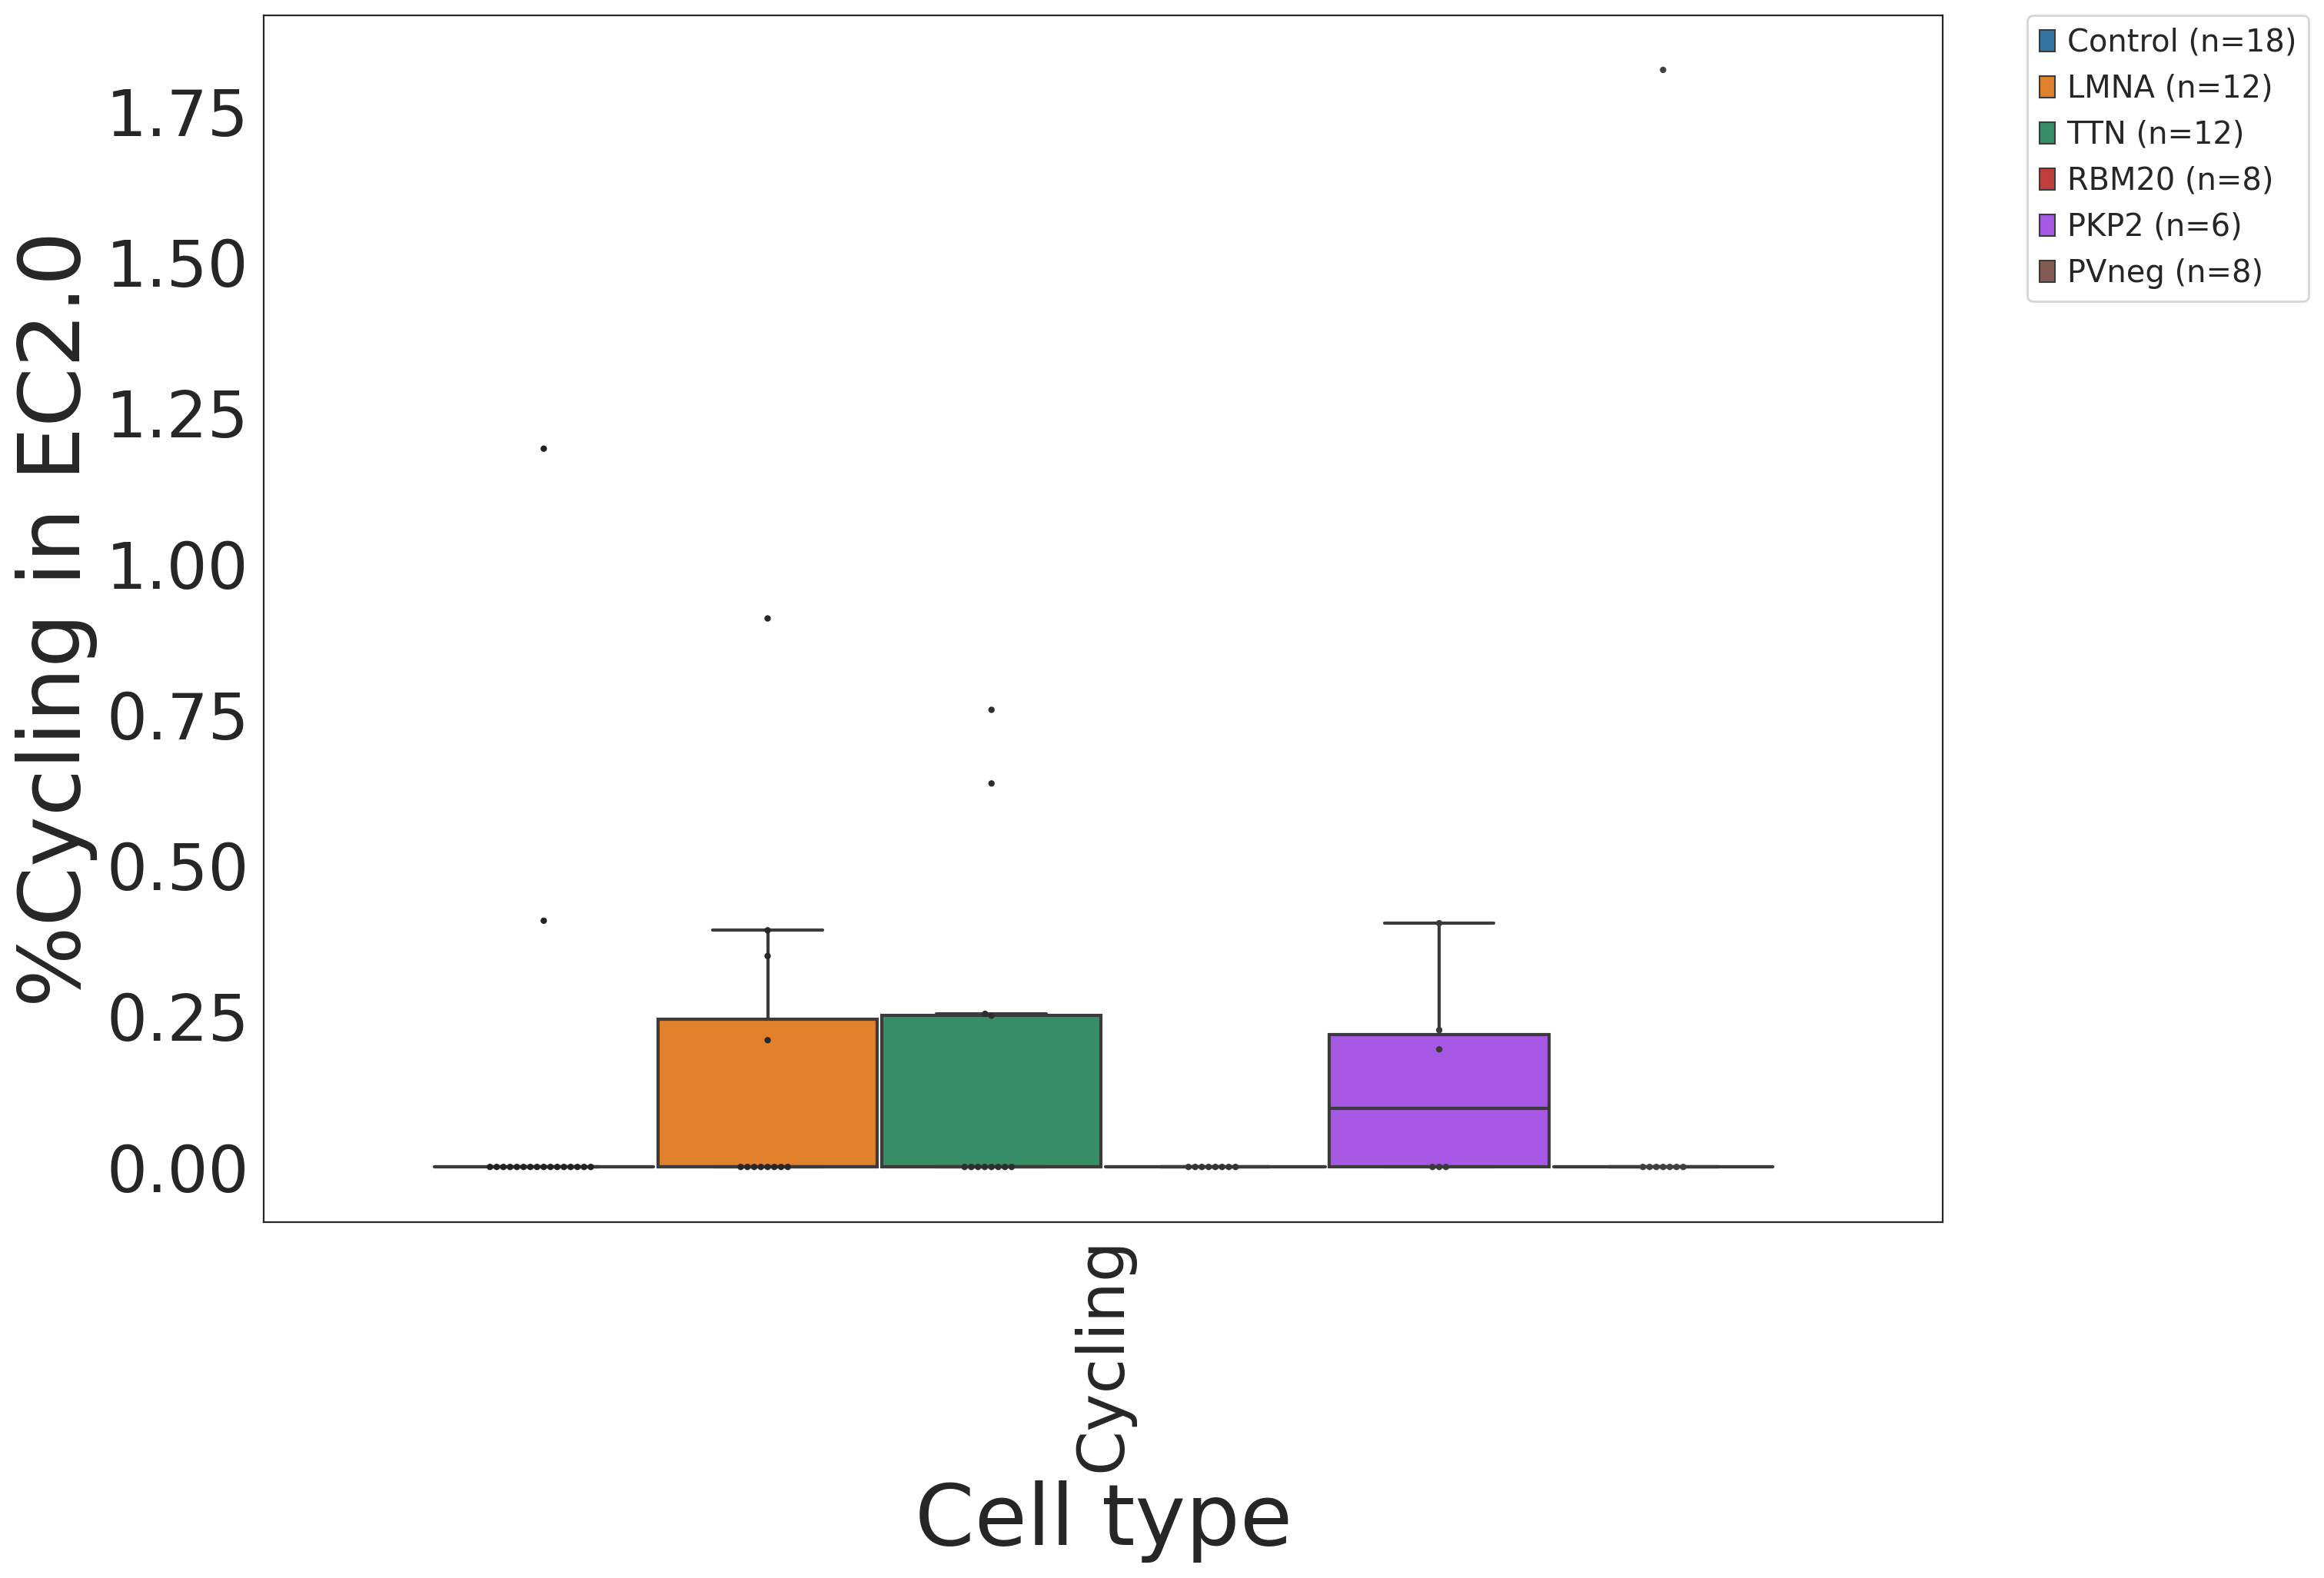

In [75]:
%matplotlib inline
plt.figure(figsize=[14,10], dpi=200, facecolor='w', edgecolor='k')
sns.set_style(style='white')
flierprops = dict(markerfacecolor='0.75', markersize=3,linestyle='none')
ax=sns.swarmplot(x="variable", y="Cycling", hue="Clinical.dominant.mutation", data=ec2_lv_g1, color=".25", dodge=True, size=3)
ax=sns.boxplot(x="variable", y='Cycling', hue="Clinical.dominant.mutation", data=ec2_lv_g1, flierprops=flierprops, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:len(set(ec2_lv_g1["Clinical.dominant.mutation"]))], labels[0:len(set(ec2_lv_g1["Clinical.dominant.mutation"]))], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("%Cycling in EC2.0",fontsize=40)
ax.set_xlabel("Cell type",fontsize=40)
ax.tick_params(labelsize=30)
plt.savefig("ec2_lv_cycling_boxplot.pdf", transparent=True)

In [76]:
ec2_rv_g1=plot_celltype_abundance(ec2_2.obs, 'RV', variable='phase', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['G1'], 
                            plottype="boxplot", 
                            show_points=True, return_table=True, save_png=None, ylimit=None)

In [77]:
ec2_rv_g1["Cycling"]=100-ec2_rv_g1["value"]

In [78]:
ec2_rv_g1["variable"] = ec2_rv_g1["variable"].replace({"G1":"Cycling"})

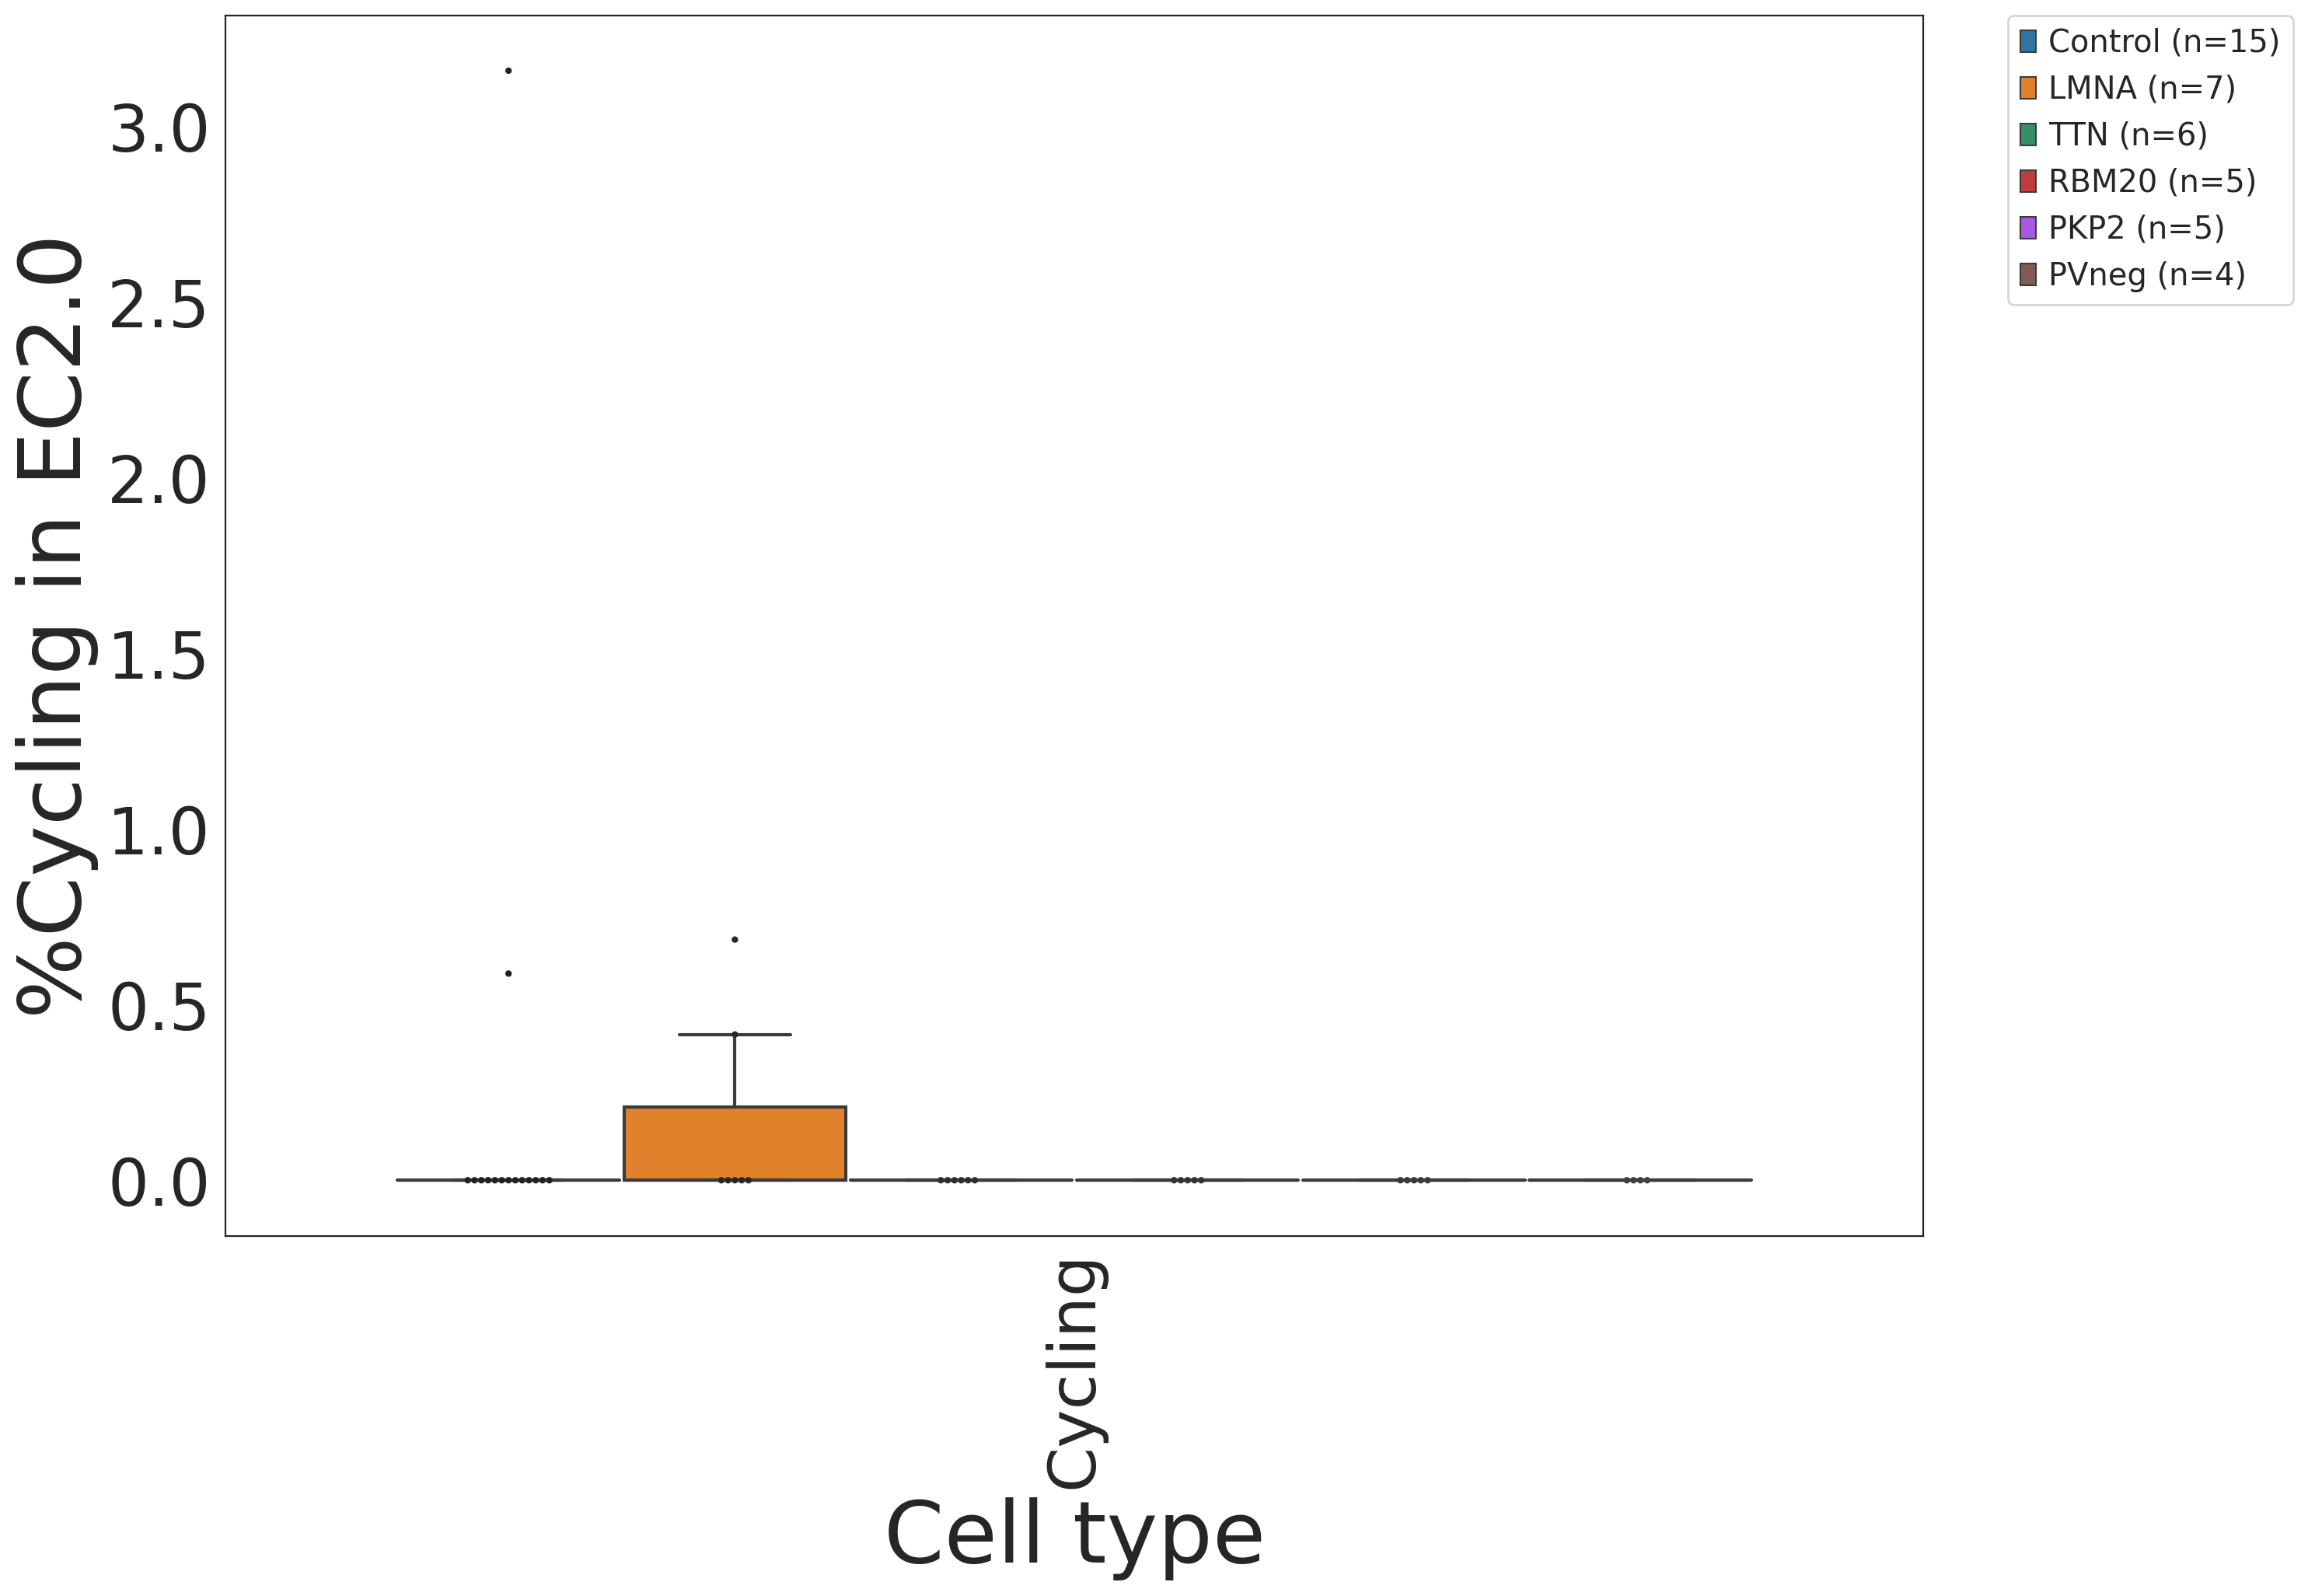

In [79]:
%matplotlib inline
plt.figure(figsize=[14,10], dpi=200, facecolor='w', edgecolor='k')
sns.set_style(style='white')
flierprops = dict(markerfacecolor='0.75', markersize=3,linestyle='none')
ax=sns.swarmplot(x="variable", y="Cycling", hue="Clinical.dominant.mutation", data=ec2_rv_g1, color=".25", dodge=True, size=3)
ax=sns.boxplot(x="variable", y='Cycling', hue="Clinical.dominant.mutation", data=ec2_rv_g1, flierprops=flierprops, showfliers = False)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:len(set(ec2_rv_g1["Clinical.dominant.mutation"]))], labels[0:len(set(ec2_rv_g1["Clinical.dominant.mutation"]))], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("%Cycling in EC2.0",fontsize=40)
ax.set_xlabel("Cell type",fontsize=40)
ax.tick_params(labelsize=30)
plt.savefig("ec2_rv_cycling_boxplot.pdf", transparent=True)

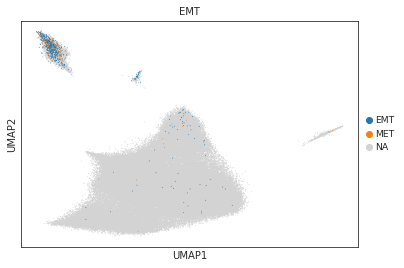

In [80]:
sc.pl.umap(ec_all_nobackground_harmony,color="EMT",groups=["EMT","MET"],size=3,save="_ec_emt.pdf") #no need to plot G1 as all remaining cells are G1 anyway. 


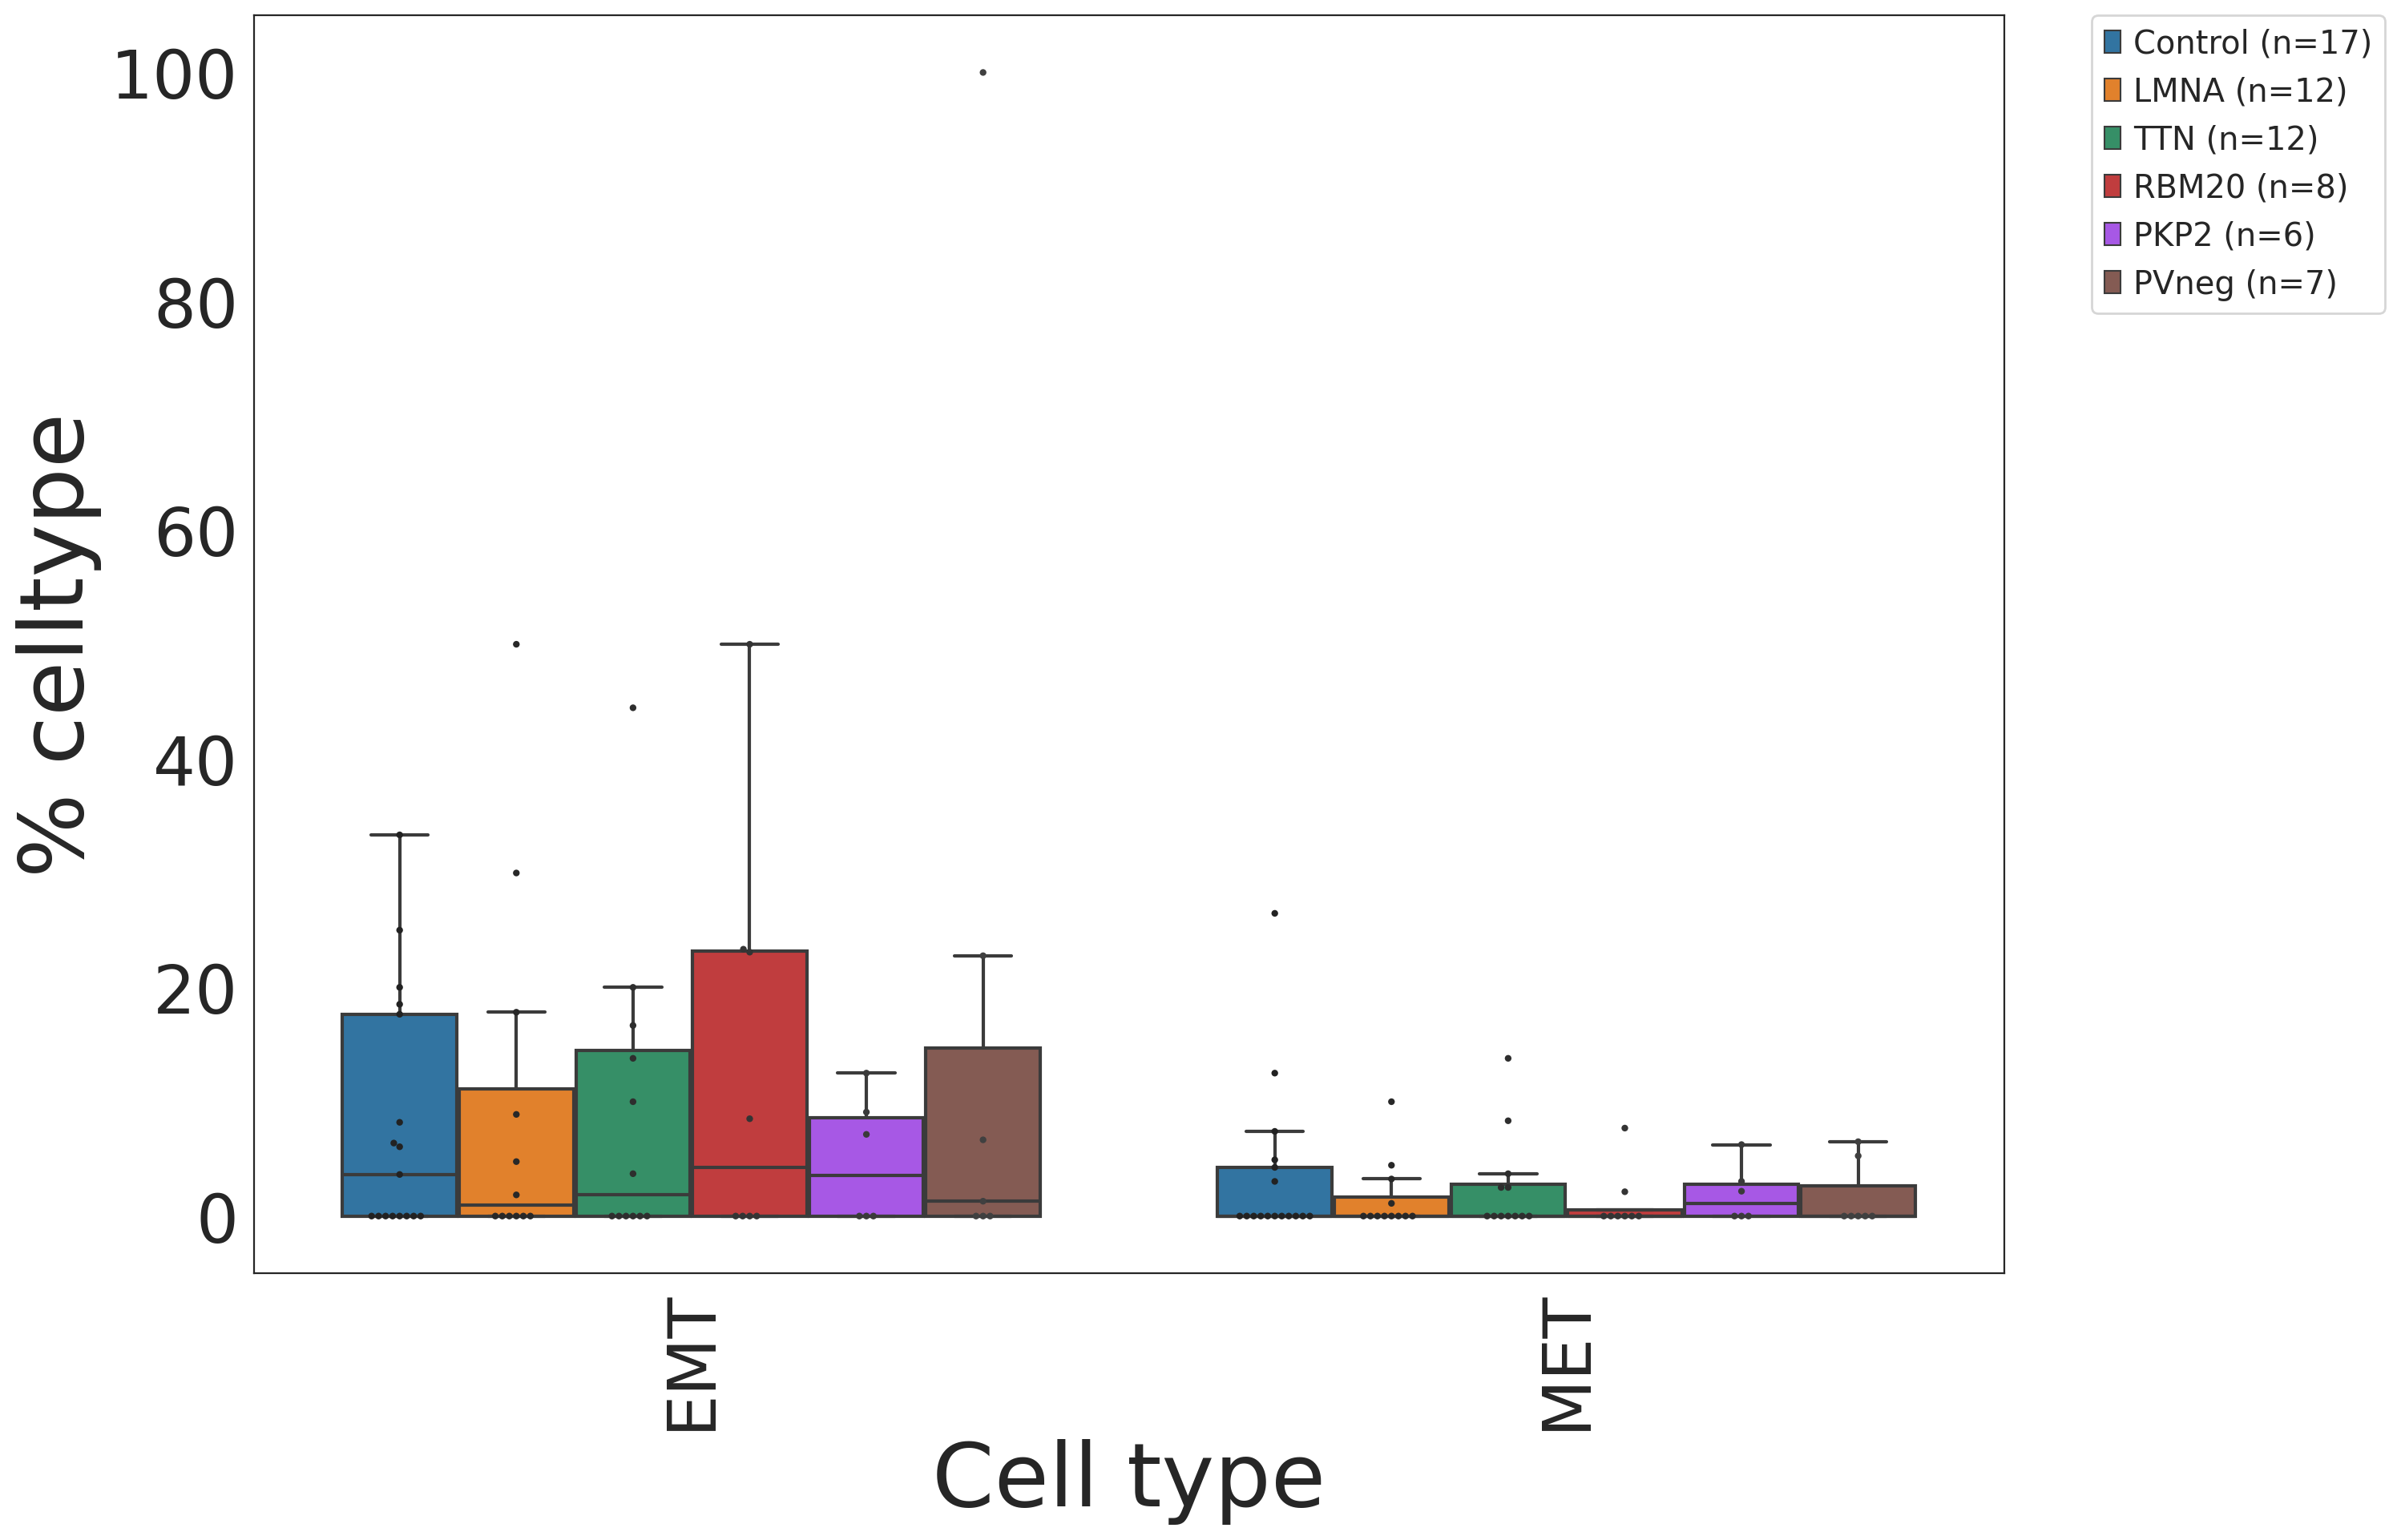

In [81]:
plot_celltype_abundance(ec7_2.obs, 'LVS', variable='EMT', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['EMT','MET'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png="ec_emt_boxplot_lv.pdf", ylimit=None)

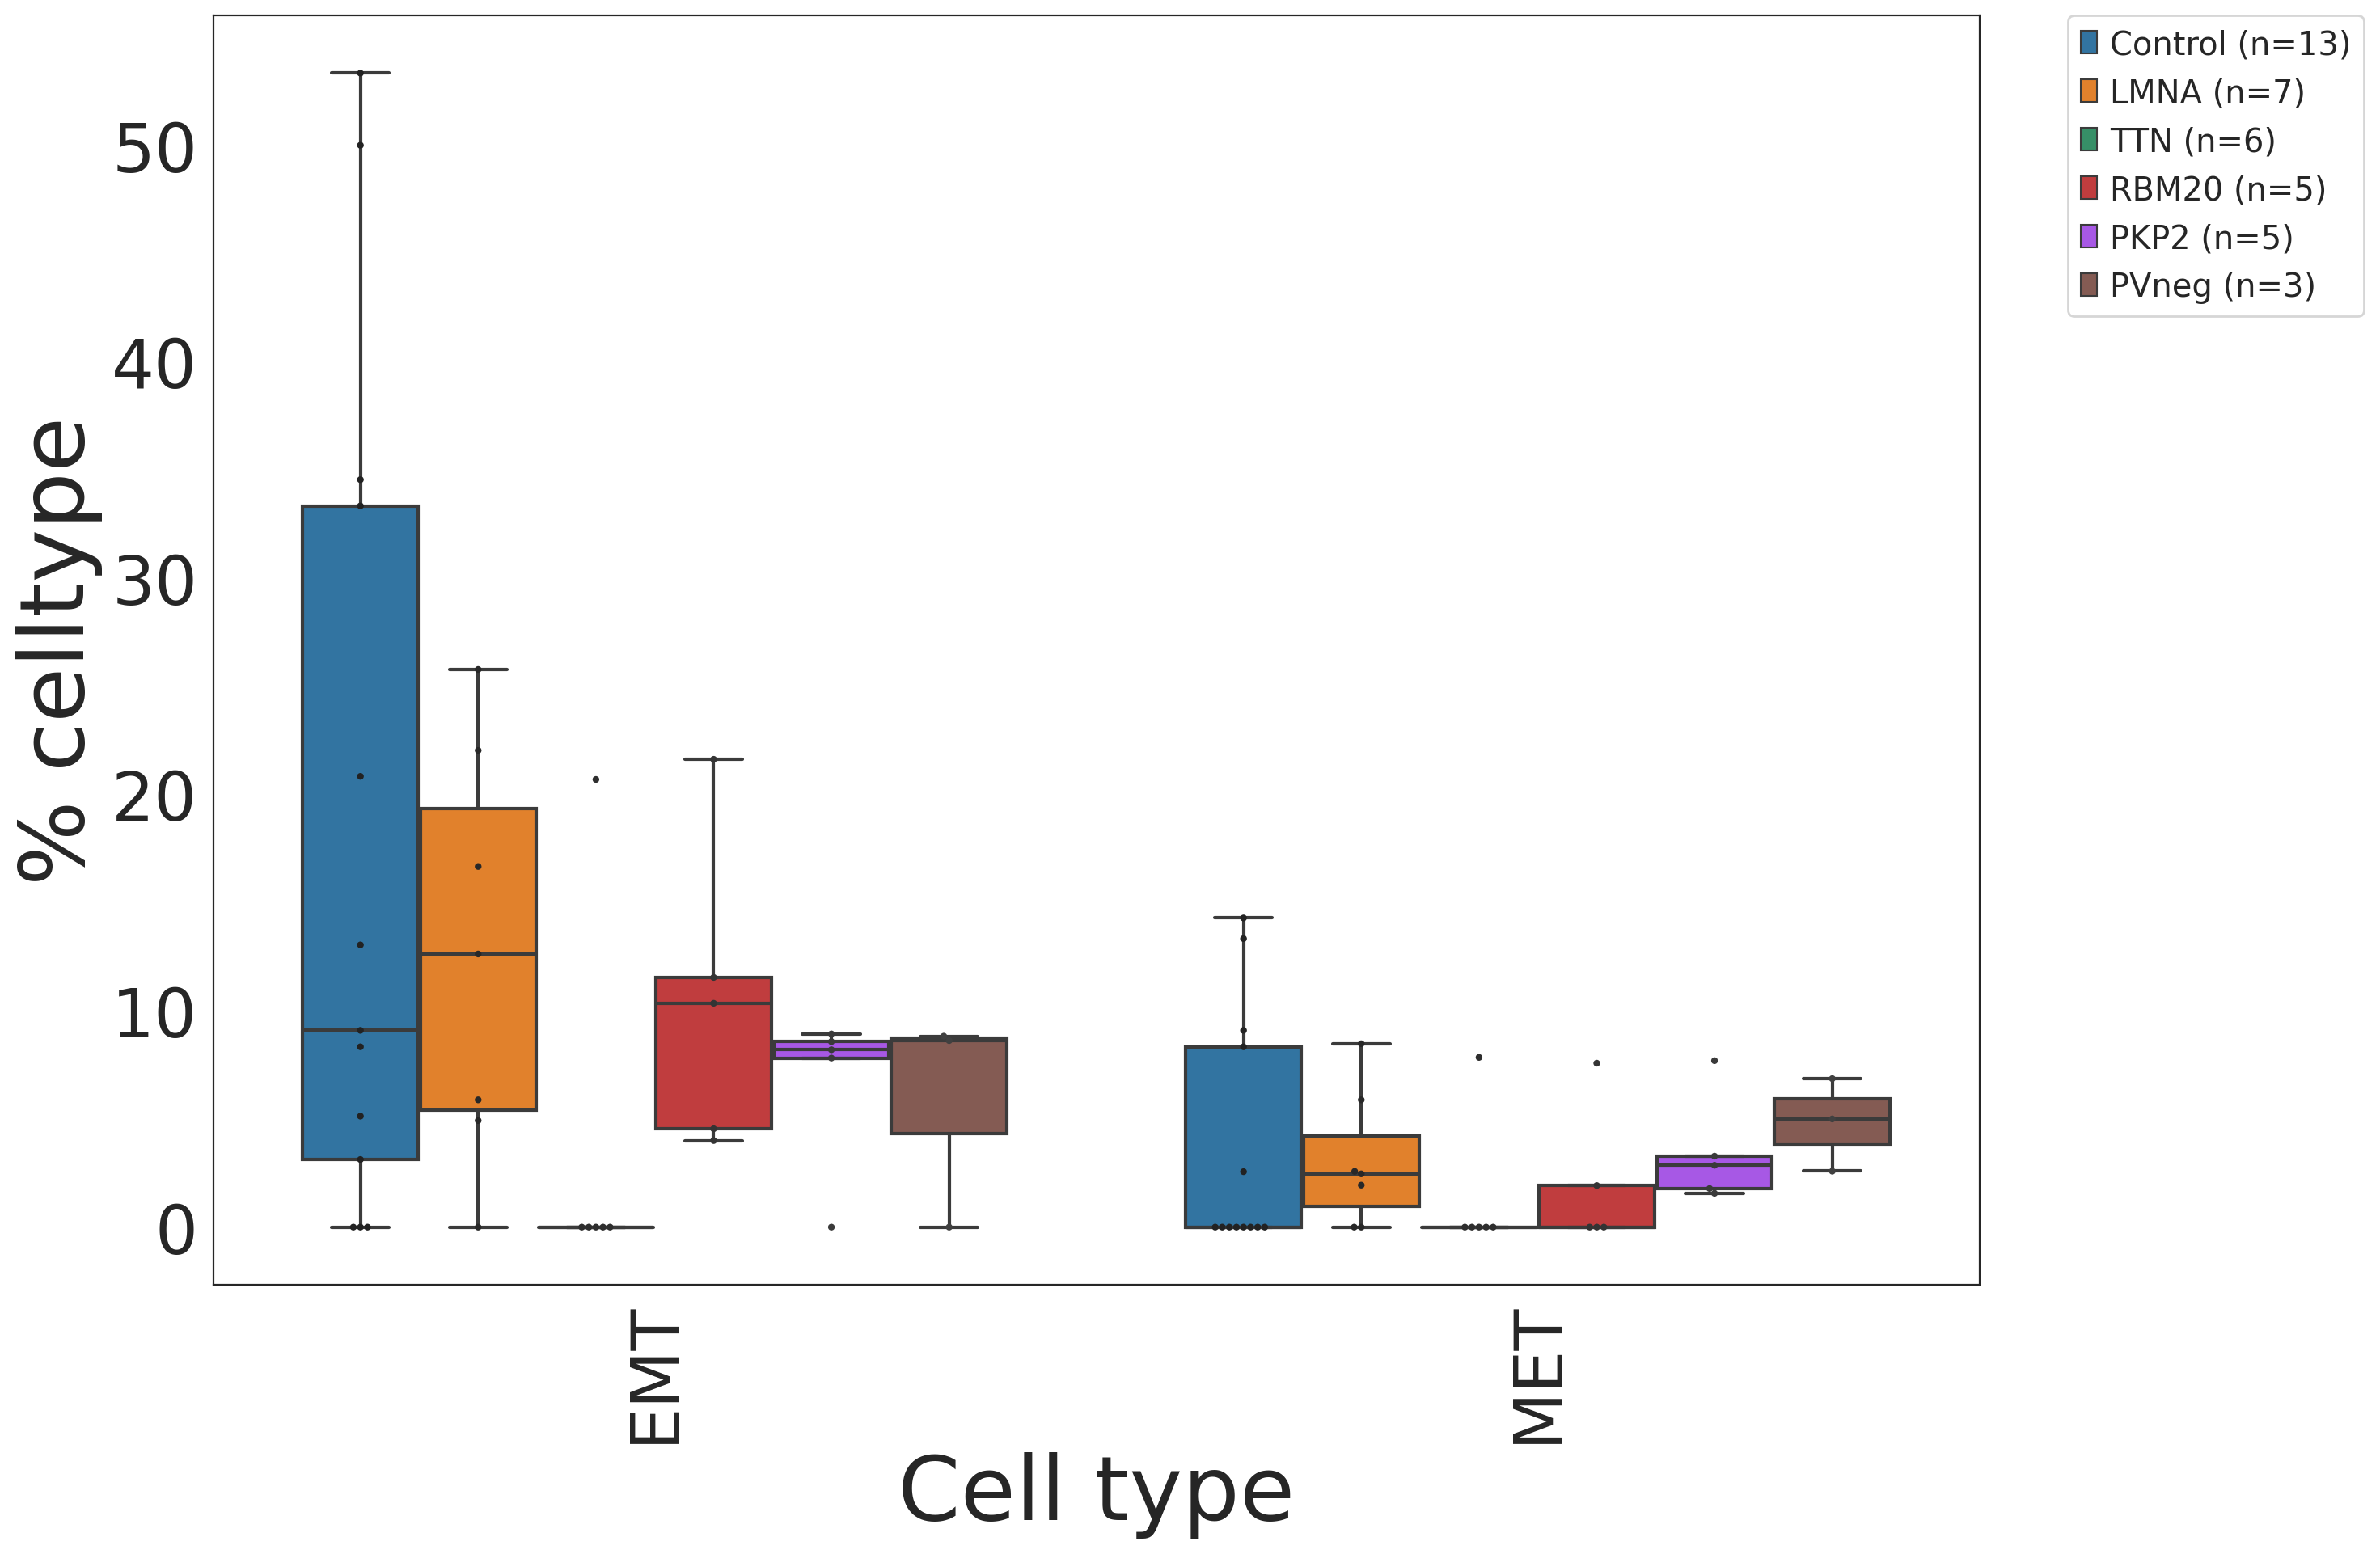

In [82]:
plot_celltype_abundance(ec7_2.obs, 'RV', variable='EMT', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['EMT','MET'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png="ec_emt_boxplot_rv.pdf", ylimit=None)

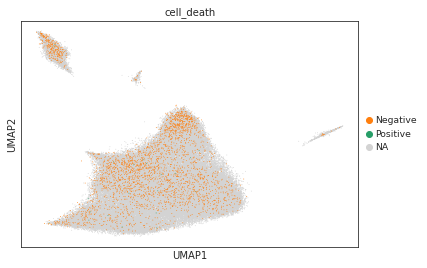

In [83]:
sc.pl.umap(ec_all_nobackground_harmony,color="cell_death",groups=["Positive","Negative"],size=3,save="_ec_rcd.pdf") #no need to plot G1 as all remaining cells are G1 anyway. 

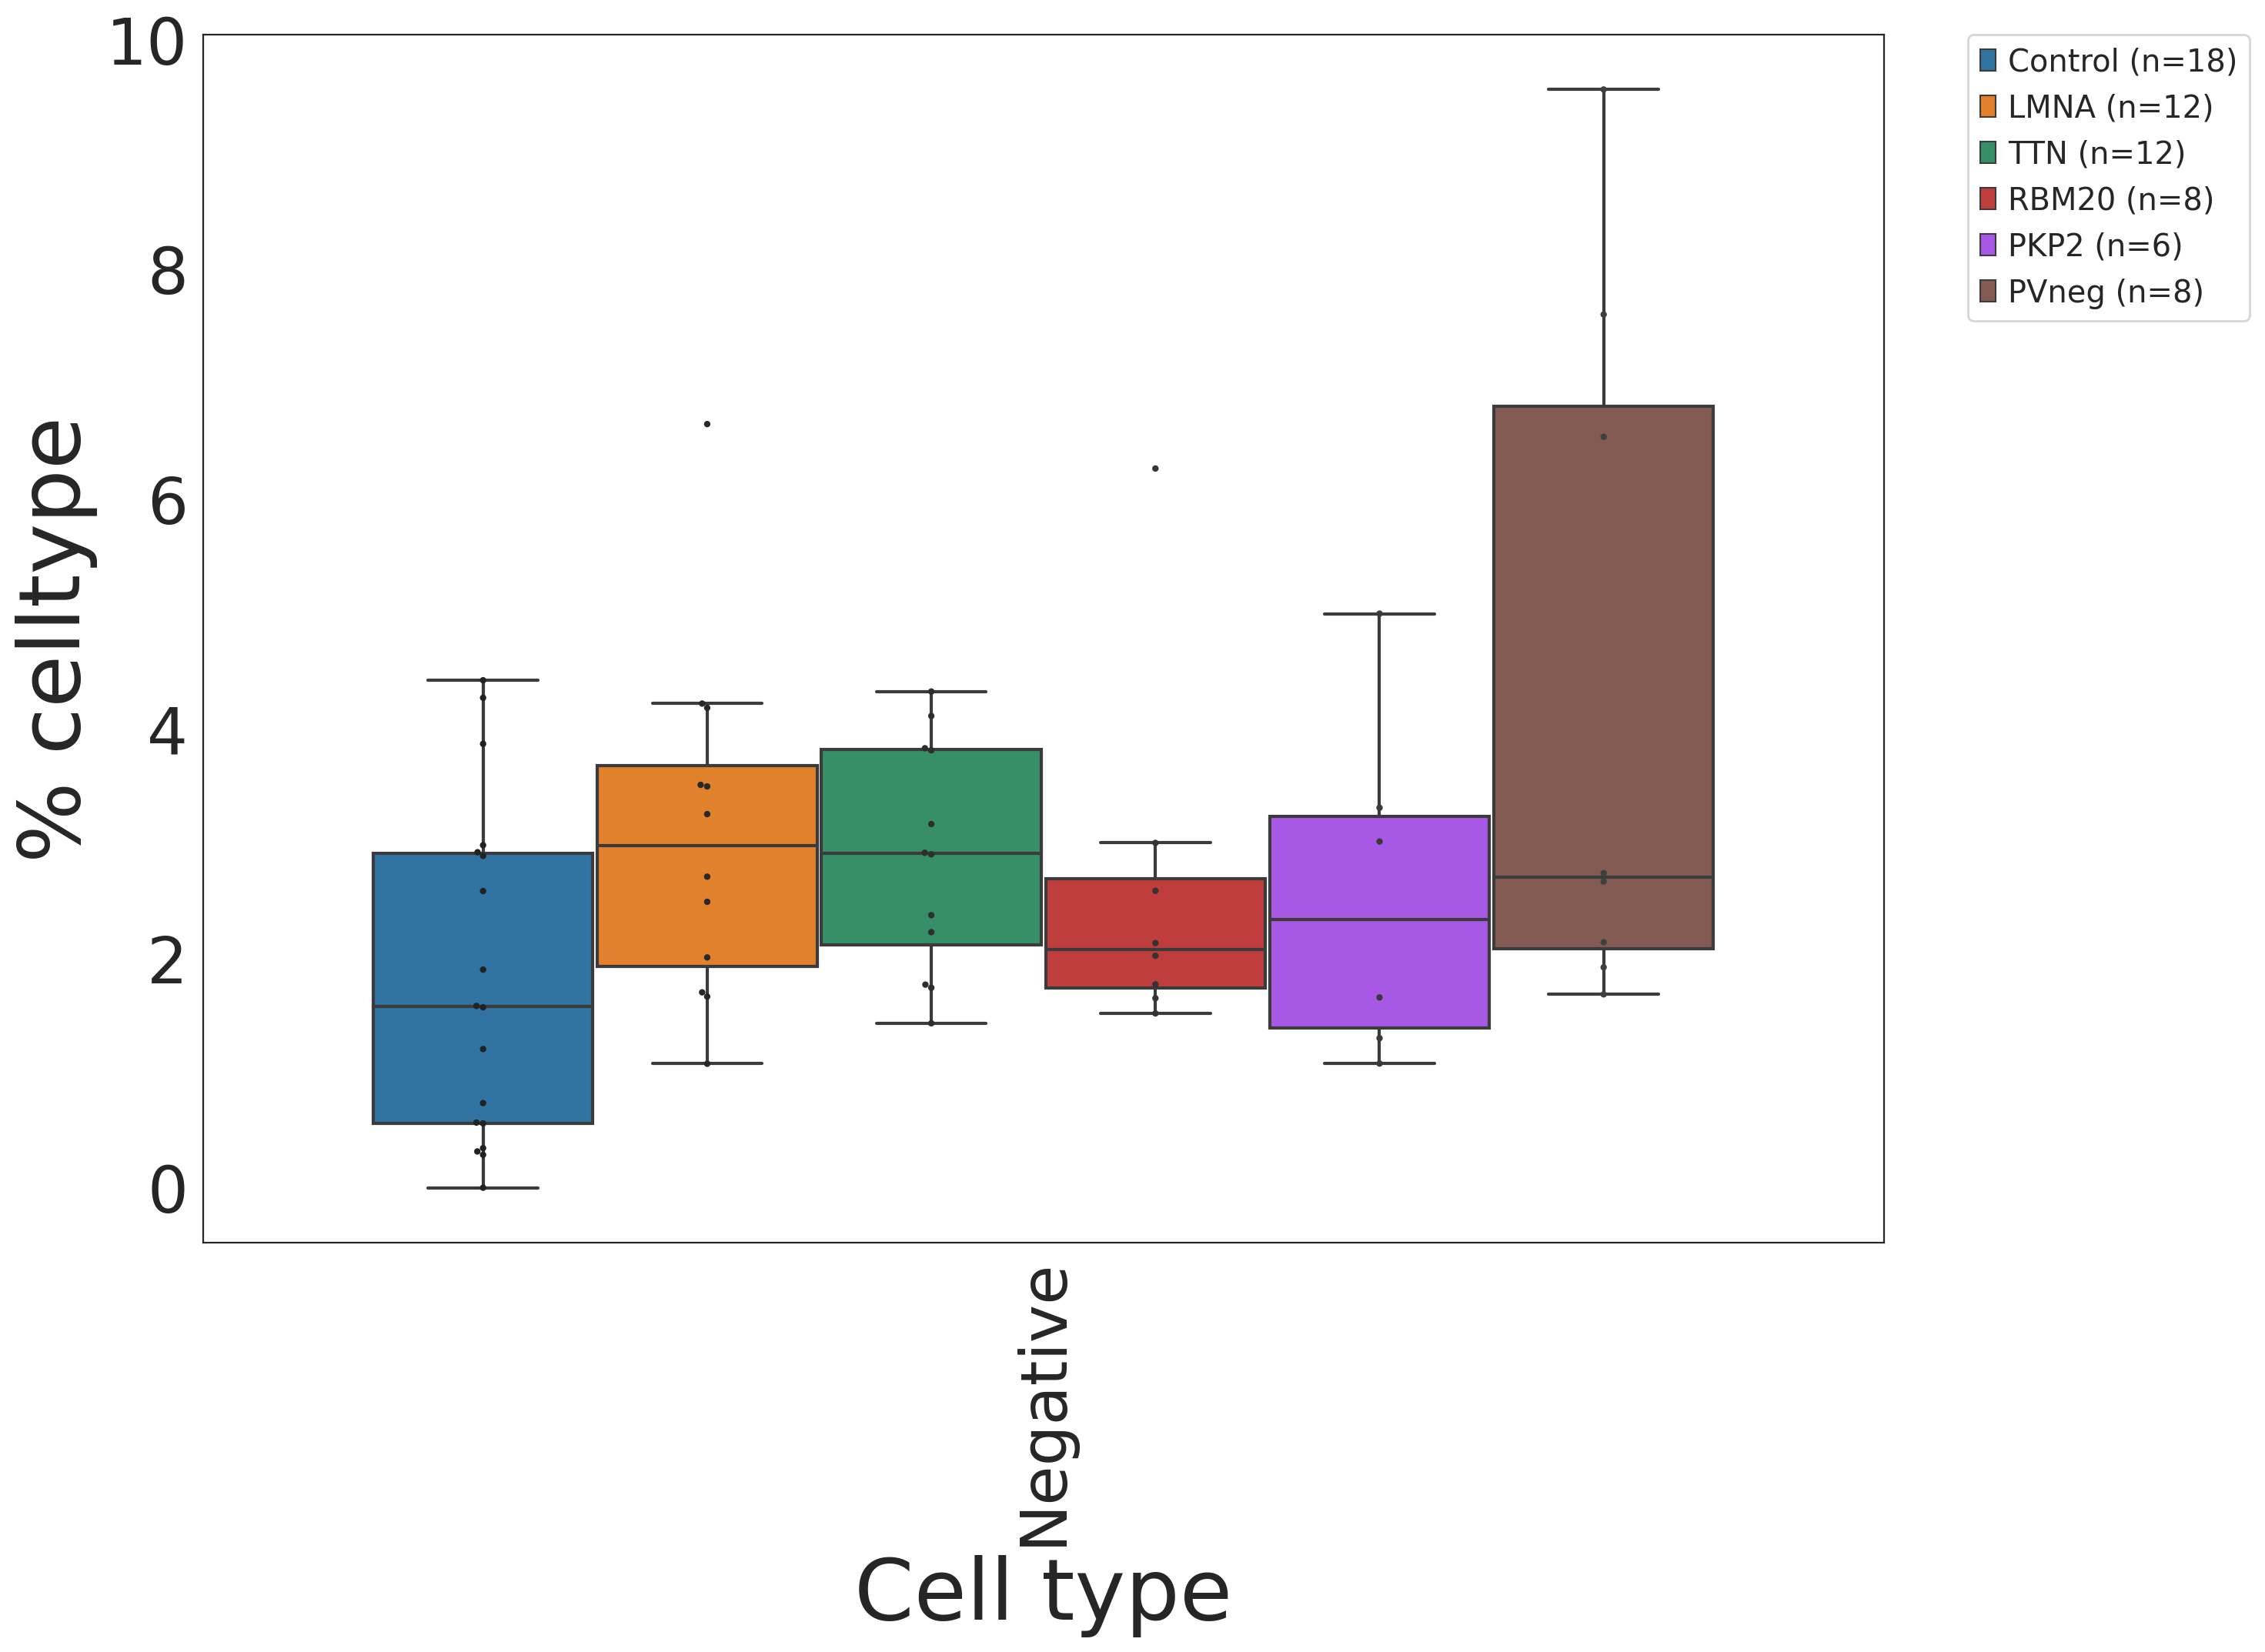

In [84]:
plot_celltype_abundance(ec_all_nobackground_harmony_2.obs, 'LVS', variable='cell_death', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['Negative'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png="ec_rcd_boxplot_lv.pdf", ylimit=None)

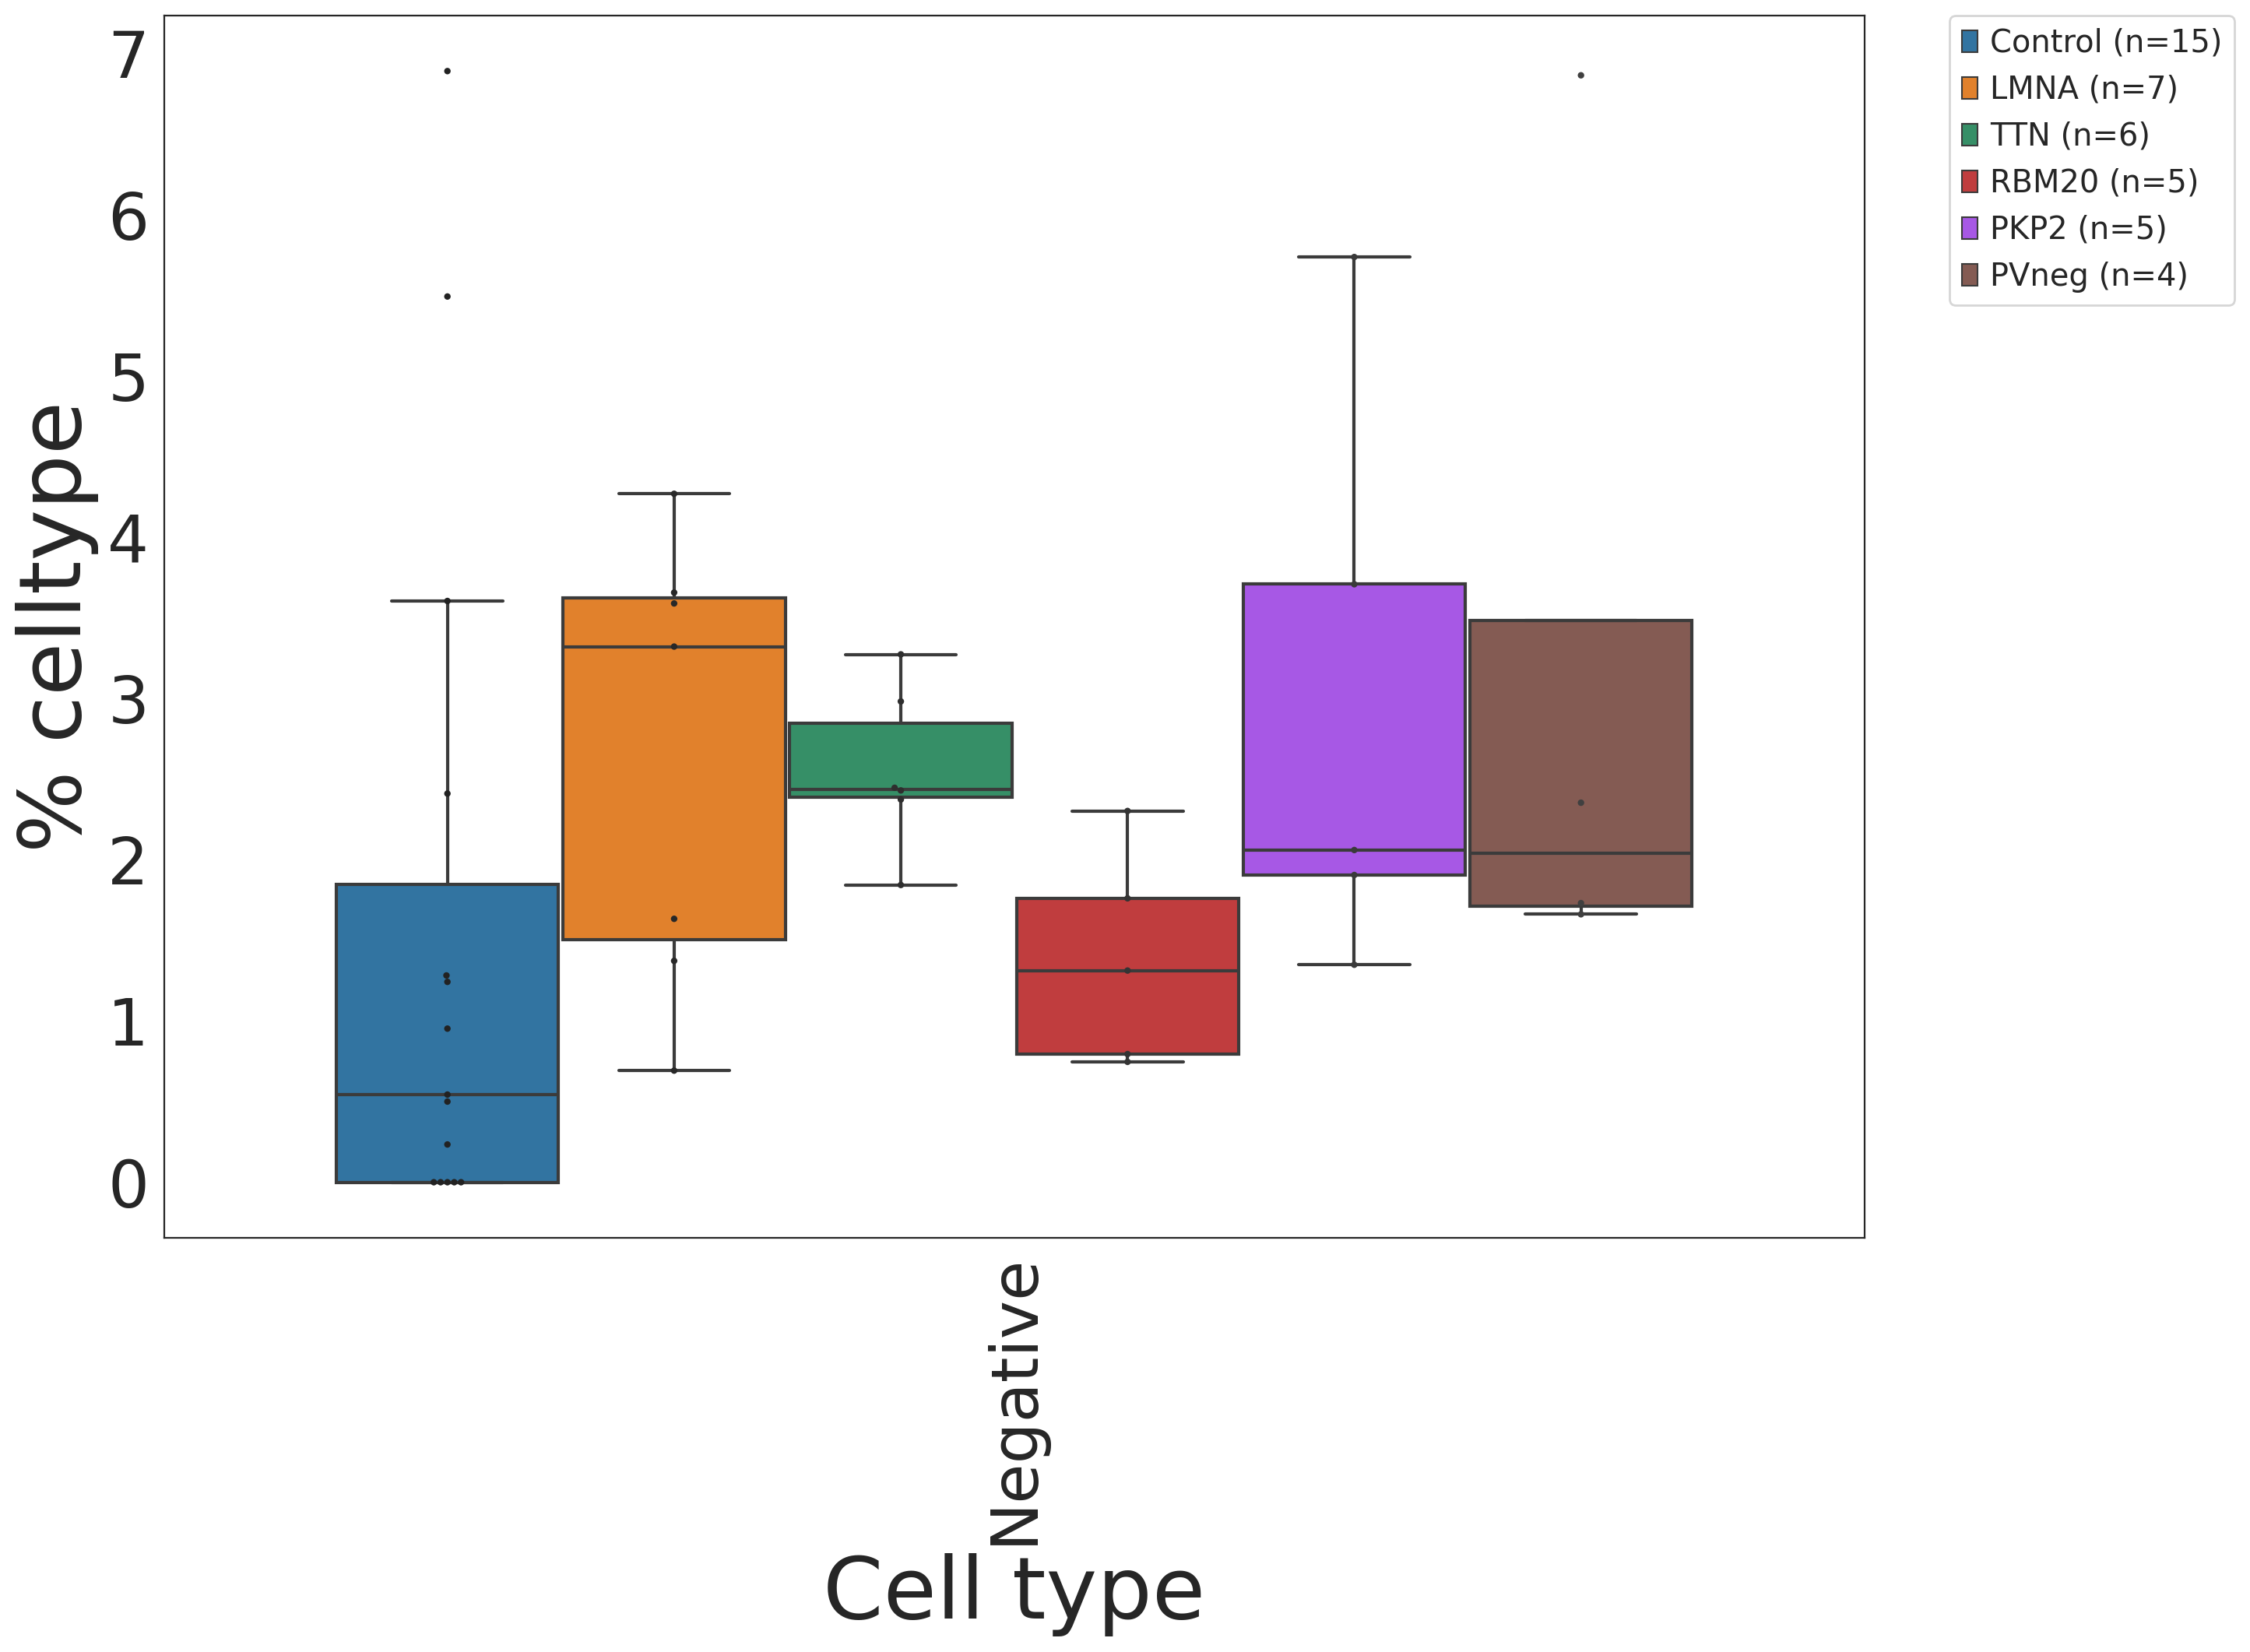

In [85]:
plot_celltype_abundance(ec_all_nobackground_harmony_2.obs, 'RV', variable='cell_death', 
                            normalised_by=None, 
                            Genes_column='Clinical.dominant.mutation',
                            Genes_to_plot=[ 'Control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'], 
                            celltypes_to_plot=['Negative'], 
                            plottype="boxplot", 
                            show_points=True, return_table=False, save_png="ec_rcd_boxplot_rv.pdf", ylimit=None)

### Extra data - supplementary tables + data currently not used

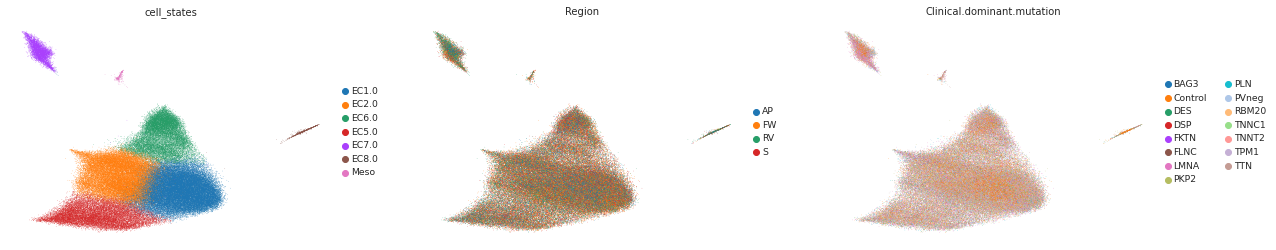

In [86]:
sc.pl.umap(ec_all_nobackground_harmony, 
           color=['cell_states', 'Region', 'Clinical.dominant.mutation', ], 
           projection='2d', components=['1,2'], frameon=False)

In [87]:
sc.tl.rank_genes_groups(ec_all_nobackground_harmony, 'cell_states', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:20:35)


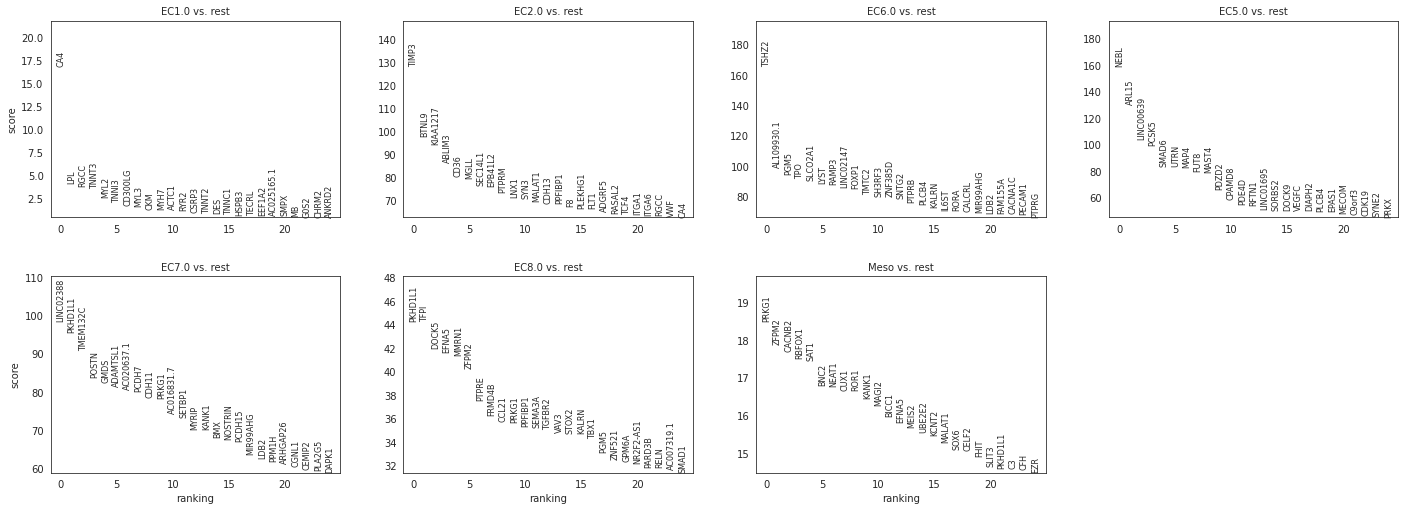

In [88]:
sc.pl.rank_genes_groups(ec_all_nobackground_harmony, n_genes=25, sharey=False)

In [89]:
expression=filter_by_expression(ec_all_nobackground_harmony, 'cell_states', key='rank_genes_groups')
expression.head(n=5)

,EC1.0_na,EC1.0_pv,EC1.0_lo,EC1.0_pi,EC1.0_po,EC1.0_ei,EC1.0_eo,EC2.0_na,EC2.0_pv,EC2.0_lo,...,EC8.0_po,EC8.0_ei,EC8.0_eo,Meso_na,Meso_pv,Meso_lo,Meso_pi,Meso_po,Meso_ei,Meso_eo
0,CA4,1.273032e-62,0.298874,0.289992,0.224986,0.286517,0.238782,TIMP3,0.0,1.779623,...,0.052048,1.601740,0.093597,PRKG1,7.967498e-72,3.747178,0.712838,0.147711,1.129588,0.144928
1,LPL,2.558724e-04,-0.009532,0.250520,0.230475,0.236403,0.237802,BTNL9,0.0,1.120037,...,0.099243,1.258327,0.089392,ZFPM2,2.691156e-67,3.535837,0.716216,0.186765,1.148688,0.170354
2,RGCC,7.111395e-04,-0.004709,0.424482,0.397228,0.426438,0.427624,KIAA1217,0.0,1.082057,...,0.064192,1.116723,0.050885,CACNB2,5.484372e-66,4.883786,0.638514,0.086176,1.092404,0.064952
3,TNNT3,1.614979e-03,0.028276,0.200624,0.184858,0.166242,0.163260,ABLIM3,0.0,1.172176,...,0.034492,1.162002,0.027156,RBFOX1,7.586416e-65,6.242620,0.614865,0.051895,1.357624,0.037417
4,MYL2,4.414963e-02,0.023046,0.534272,0.524003,0.517919,0.511579,CD36,0.0,1.061185,...,0.006260,1.166111,0.005508,SAT1,1.807554e-64,4.431270,0.662162,0.140831,1.341976,0.123098


In [90]:
expression.to_csv(path_out + "EC_CELLSTATE_DEG_WILCOX.csv")

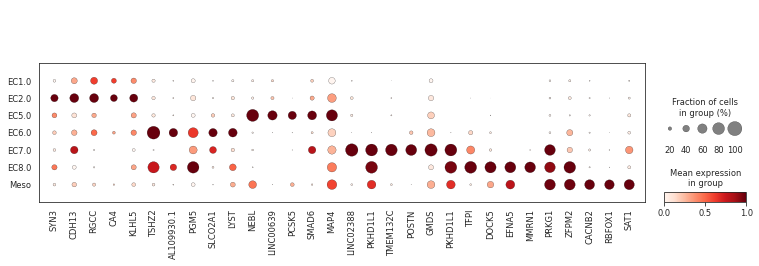

In [91]:
sc.pl.dotplot(ec_all_nobackground_harmony,
              makevector_topmarkers(ec_all_nobackground_harmony, 
                                    5, ldFC_cutoff=1, pvals_adj_cutoff=10**-10, expression_in=0.2,expression_out=0.5),
              groupby='cell_states', use_raw=True,categories_order=["EC1.0","EC2.0","EC5.0","EC6.0","EC7.0","EC8.0","Meso"],dot_max=1,dot_min=0.05,standard_scale="var")

Mean CV accuracy: 0.8083
Accuracy on the training set: 0.9995
Accuracy on the hold-out set: 0.7596


<Figure size 1960x1400 with 0 Axes>

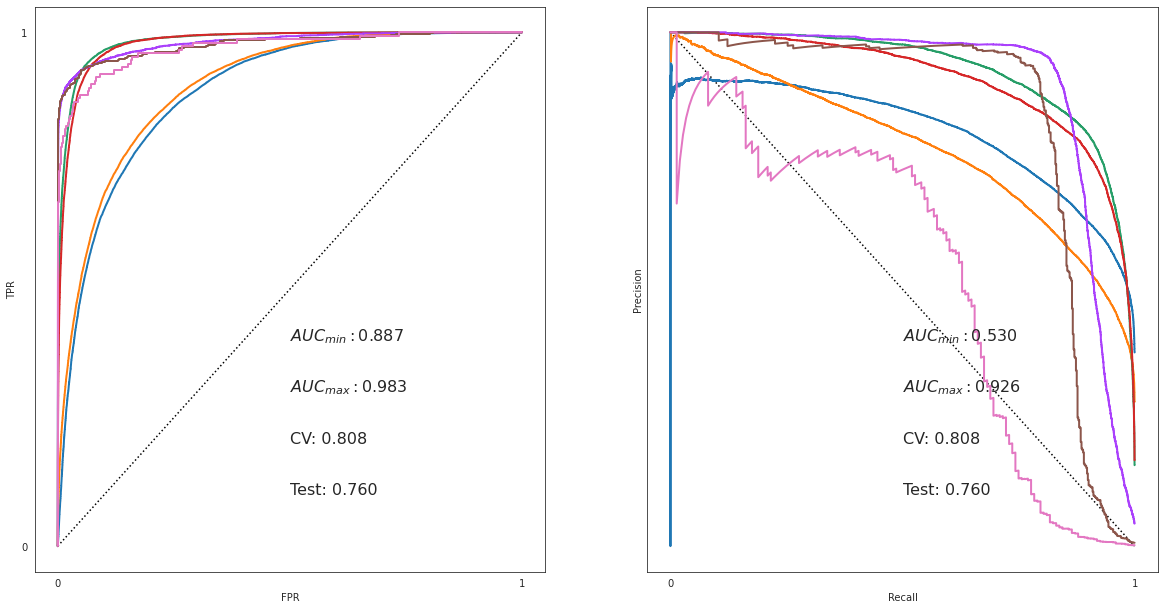

In [92]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.figure(figsize=[14,10], dpi=140, facecolor='w', edgecolor='k')
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ec_all_nobackground_harmony.X, 
                                                          ec_all_nobackground_harmony.obs['cell_states'],n=1000)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [93]:
pip list

Package                 Version    
----------------------- -----------
absl-py                 0.7.1      
alembic                 1.0.9      
aniso8601               8.0.0      
anndata                 0.7.4      
annoy                   1.16.2     
arboreto                0.1.5      
arrow                   0.15.7     
asn1crypto              0.24.0     
astor                   0.7.1      
async-generator         1.10       
attrs                   19.3.0     
backcall                0.2.0      
bbknn                   1.3.6      
bhtsne                  0.1.9      
bleach                  1.5.0      
boltons                 20.1.0     
boto3                   1.7.84     
botocore                1.10.84    
CellPhoneDB             2.1.1      
certifi                 2020.6.20  
cffi                    1.13.2     
chardet                 3.0.4      
click                   6.7        
cloudpickle             1.4.1      
cmake                   3.17.3     
colorama                0.4.